In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from collections import Counter
import benfords 
from scipy.stats import chisquare, ks_2samp, pearsonr
from itertools import product
import networkx as nx
from sklearn.linear_model import LinearRegression

### CDF Calculator Based on Observations

In [3]:
class Distribution:
    def __init__(self, observations):
        self.observations = observations
        self.cumulative_probs, self.sorted_data, self.sorted_unique_values = self.preprocess() 
        
    def preprocess(self):
        sorted_data = np.sort(self.observations)
        unique_values, counts = np.unique(sorted_data, return_counts=True)
        return np.cumsum(counts) / len(sorted_data) , sorted_data, unique_values
    
    def cdf(self, x):
        if x < self.sorted_data[0]:
            return 0
        elif x > self.sorted_data[-1]:
            return 1
        else:
            return self.cumulative_probs[np.searchsorted(self.sorted_unique_values, x, side='right') - 1]


### - Lawrence Metric

In [4]:
class LawrenceBenfordCheck:
    def __init__(self, cdf, domain):
        self.cdf = cdf
        self.domain = domain


    # Interpretation:
    # - High R-squared: Suggests good fit to the linear model, indicating possible linearity
    # - Low R-squared: Suggests non-linearity
    def r_square(self, x, y):
        model = LinearRegression()
        model.fit(x.reshape(-1, 1), y)
        r_squared = model.score(x.reshape(-1, 1), y)
        print(f"R-squared: {r_squared:.4f}")

    # Interpretation:
    # - Close to 1: Strong positive linear relationship
    # - Close to 0: Weak or non-linear relationship
    # - Close to -1: Strong negative linear relationship
    # - A low p-value indicates rejecting the null hypothesis of non-linearity.
    def pearson(self, x, y):
        r, p = pearsonr(x, y)
        print('Linearity Check:')
        print(f'Pearson Coefficient: {r}, P-Value: {p}')
        
        
    def check_linearity(self, x, y):
        self.pearson(x, y)
        self.r_square(x ,y)
        
    def compare_cdf_with_benford(self, precision = 1000):
        z_vals = np.linspace(0, 1, precision)
        cdf = np.array([
            self.calculate_cumulative_prob(z) for z in z_vals
        ])
        self.check_linearity(z_vals, cdf)
        plt.plot(z_vals, cdf, label = 'Lawrence function')
        plt.xlabel('z')
        plt.ylabel('Pr(Z ≤ z)')
        plt.legend()
        plt.show()

    def calculate_cumulative_prob(self, z):
        d_vals = np.arange(-self.domain, self.domain + 1, 1, dtype= float)
        return sum([
            self.calculate_mixture_prob(d, z) for d in d_vals
        ])

    def calculate_mixture_prob(self, d, z):
        return self.cdf(10**(d+z)) - self.cdf(10**d)

In [5]:
class BenfordAnalyzer:
    def __init__(self):
        self.data = None
        self.first_digits_freq = None
        self.first_digits = None 
        
    def get_first_digits_freq(self):
        if self.first_digits_freq is None:
            self.first_digits_freq = self.count_first_digits(self.data)
        return self.first_digits_freq
    
    def get_first_digits(self):
        if self.first_digits is None:
            self.first_digits = self.extract_first_digits(self.data)
        return self.extract_first_digits(self.data)
    
    def set_data(self, data):
        self.data = data
        self.first_digits_freq = None 
        self.first_digits = None 
        
    def extract_first_digits(self, data):
        return np.array([int(format(abs(float(x)), ".6e")[0]) for x in data if x != 0 and x != np.inf])
    
    def count_first_digits(self, data):
        counts = Counter(self.extract_first_digits(data))
        return [counts[d] for d in range(1, 10)]
    
    def get_combined_benford(self, digit_lists):
        all_combs = list(product(*digit_lists))
        return sum([
            self.get_benford(comb) for comb in all_combs
        ])
    
    def get_benford(self, digits):
        if len(digits) == 0: 
            raise ValueError('No digits provided')
        sigma = sum( [digits[i]*10**(len(digits) - i - 1) for i in range(len(digits))] )
        return np.log10(1 + 1 / sigma)
    
    def get_benford_rvs(self, size):
        uniform_data = np.random.uniform(low=0.0, high=1.0, size=size)
        return 10**uniform_data
    

    def get_benford_probes(self):
        return np.array([self.get_benford([i]) for i in range(1, 10)])
    
    
    def get_benford_freq(self, count):
        probes = self.get_benford_probes()
        return np.array([count * probes[i] for i in range(9)])
    
    
    def show_benford_diff(self):
        first_digits_count = self.get_first_digits_freq()
        benford_freq = self.get_benford_freq(len(self.data))
        digits = list(range(1, 10))
        benford_diff = [abs(first_digits_count[d-1] - benford_freq[d-1]) for d in digits]
        plt.plot(digits, first_digits_count, color='violet', label='Actual', alpha=0.5)
        plt.plot(digits, benford_freq, color='red', label='Benford', alpha=0.5)
        plt.bar(digits, benford_diff, color='green', label='Difference', alpha=0.5)
        plt.xlabel('First Digit')
        plt.ylabel('Frequency')
        plt.title('Difference with Benford')
        plt.legend()
        plt.show()
        plt.close()
    
    def show_benford_diff_2(self):
        benfords.benfords(self.data, output_plot=True)
    
    def show_benford_diff_bars(self):
        first_digits_count = self.get_first_digits_freq()
        benford_freq = self.get_benford_freq(len(self.data))
        
        # X-axis labels
        categories = np.arange(1, len(first_digits_count) + 1)
        
        # Plot the first distribution
        plt.bar(categories - 0.2, first_digits_count, width=0.4, label='Observed')
        
        # Plot the second distribution
        plt.bar(categories + 0.2, benford_freq, width=0.4, label='Benford')
        
        # Add labels and title
        plt.xlabel('Digits')
        plt.ylabel('Frequency')
        plt.title('Benford - Observed')
        plt.legend()
        plt.show()
        plt.close()

        
    def calculate_chisquare(self):
        first_digits_freq = np.array(self.get_first_digits_freq())
        benford_freq = np.array(self.get_benford_freq(len(self.data)))
        statistic, p_value = chisquare(first_digits_freq, benford_freq)
        return statistic, p_value
    
    def lawrence_diff(self):
        first_digits_freq = self.get_first_digits_freq()
        s =  sum(first_digits_freq)
        first_digits_probes = [i/s for i in first_digits_freq]
        benford_probes = self.get_benford_probes()
        c = sum([
            (first_digits_probes[i] - benford_probes[i])**2 / benford_probes[i] for i in range(9)
        ])
        m = max([
            abs(first_digits_probes[i] - benford_probes[i]) for i in range(9)
    
        ])
        return c, m 
            
    def calculate_mad(self):
        first_digits_freq = self.get_first_digits_freq()
        s =  sum(first_digits_freq)
        first_digits_probes = [i/s for i in first_digits_freq]
        benford_probes = self.get_benford_probes()
        abs_diffs = [abs(first_digits_probes[i] - benford_probes[i]) for i in range(9)]
        mad =  sum(abs_diffs) / len(abs_diffs)
        result = 'close' 
        if 0.0012 <= mad <= 0.0018:
            result = 'acceptable'
        elif 0.0018 <= mad <= 0.0022:
            result = 'marginally'
        else:
            result = 'None'
        return mad, result
            
    # H0 : There is no actual correlation between the two variables
    def calculate_pearsonr(self):
        first_digits_freq = self.get_first_digits_freq()
        benford_freq = self.get_benford_freq(len(self.data))
        statistic, p_value =  pearsonr(first_digits_freq, benford_freq)
        return statistic, p_value       
        
    def calculate_ks(self, benford_rvs):
        first_digits = np.array(self.get_first_digits())
        benford_first_digits = np.array(self.extract_first_digits(benford_rvs))
        return ks_2samp(first_digits, benford_first_digits)
    
    def calculate_j_divergence(self):
        first_digits_count = self.count_first_digits(self.data)
        first_digits_probes = np.array(first_digits_count) / sum(first_digits_count)
        benford_probes = self.get_benford_probes()
        j_divergence = sum([
            first_digits_probes[i] * np.log2(first_digits_probes[i] / benford_probes[i]) + 
            benford_probes[i] * np.log2(benford_probes[i] / first_digits_probes[i]) 
            for i in range(9)
        ])
        return j_divergence 

    def report(self):
        benford_rvs = self.get_benford_rvs(len(self.data))
        ks, ks_result = self.calculate_ks(benford_rvs)
        chi2, chi2_result = self.calculate_chisquare()
        pearson, pearson_result = self.calculate_pearsonr()
        c, m  = self.lawrence_diff()
        mad, mad_result = self.calculate_mad()
        
        print(f'Chi2 Statistic: {chi2}, Chi2 P-Value: {chi2_result}')
        print(f'Lawrence Statistics-> c: {c}, m: {m}')
        print(f'MAD Statistic: {mad}')
        print(f'MAD result: {mad_result}')
        print(f'KS Statistic: {ks} KS P-Value: {ks_result}')    
        print(f'Pearson Statistic: {pearson} Pearson P-Value: {pearson_result}')
        print(f'J-Divergence: {self.calculate_j_divergence()}')
        self.show_benford_diff()
        self.show_benford_diff_bars()
        

## Check Benford for survival distributions

In [6]:
from scipy.stats import expon, lognorm, gamma, beta, loggamma,  triang, zipf, burr, invgamma, levy, invgauss, invweibull, cauchy, weibull_min, cauchy 

# Check Benford for survival distributions
SAMPLE_SIZE = 100000
LAWRENCE_DOMAIN = 20

analyzer = BenfordAnalyzer()
analyzer.get_combined_benford([[1,2,3,4,5,6,7,8,9], [2]]) # ~0.109

0.10882149900550823

Chi2 Statistic: 107.5619288277621, Chi2 P-Value: 1.2061488639393044e-19
Lawrence Statistics-> c: 0.0010756192882776202, m: 0.010719995663981186
MAD Statistic: 0.0033741727037874952
MAD result: None
KS Statistic: 0.015829999999999955 KS P-Value: 2.587920874118957e-11
Pearson Statistic: 0.9993728222798193 Pearson P-Value: 2.0330093685157347e-11
J-Divergence: 0.0015440065580711064


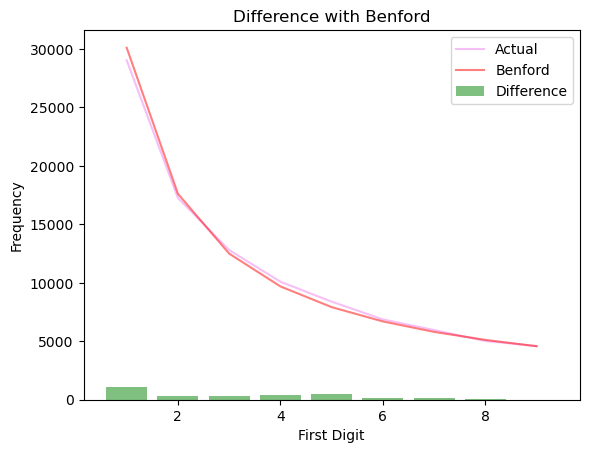

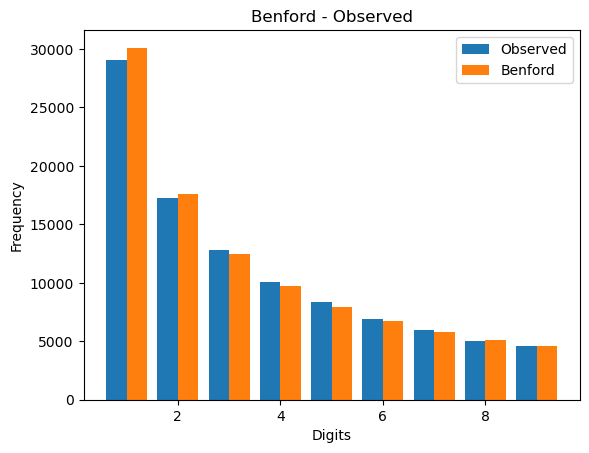

Linearity Check:
Pearson Coefficient: 0.9998350015249441, P-Value: 0.0
R-squared: 0.9997


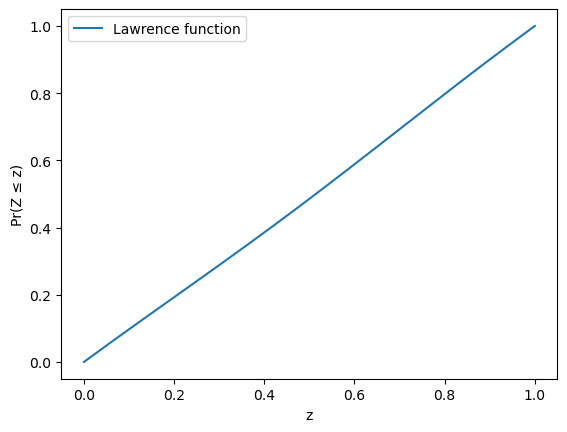

In [7]:
lognorm_rv = lognorm(s = 1, scale = 0.5)
data = lognorm_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()

lbc = LawrenceBenfordCheck(lognorm_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

#### - Weibull

Chi2 Statistic: 617.2664758409758, Chi2 P-Value: 4.5362076909147005e-128
Lawrence Statistics-> c: 0.006172664758409761, m: 0.029070004336018807
MAD Statistic: 0.007486664739547191
MAD result: None
KS Statistic: 0.02816000000000002 KS P-Value: 7.047409518055222e-35
Pearson Statistic: 0.9955324231161635 Pearson P-Value: 1.9538953905849637e-08
J-Divergence: 0.00895302602030929


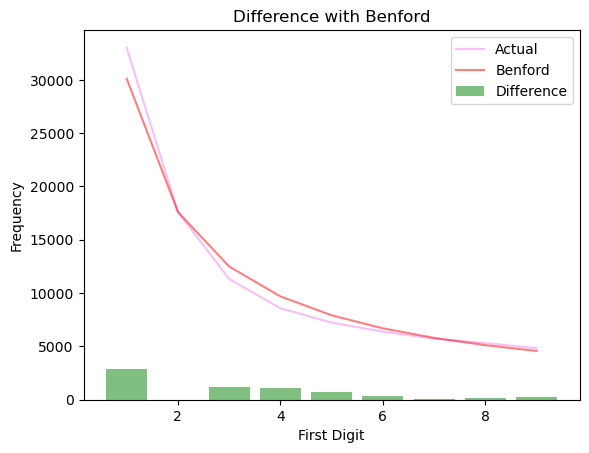

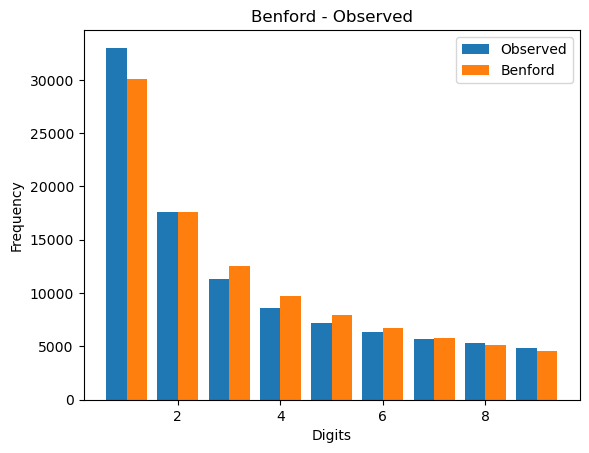

Linearity Check:
Pearson Coefficient: 0.9992911002602028, P-Value: 0.0
R-squared: 0.9986


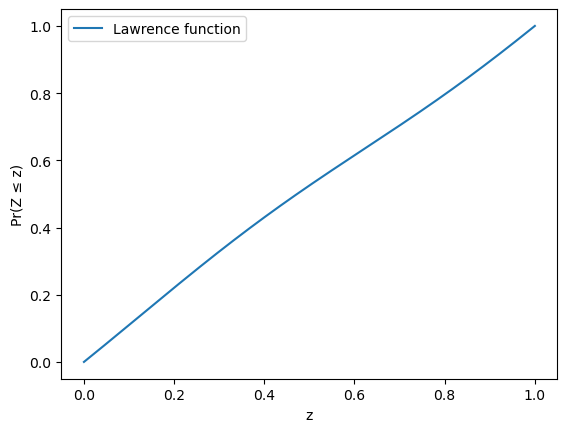

Chi2 Statistic: 6.841017867370606, Chi2 P-Value: 0.5538789361848802
Lawrence Statistics-> c: 6.841017867370622e-05, m: 0.0018187366082999396
MAD Statistic: 0.0006425020123736075
MAD result: None
KS Statistic: 0.0019700000000000273 KS P-Value: 0.9899415820219171
Pearson Statistic: 0.9999404926251229 Pearson P-Value: 5.351920978113798e-15
J-Divergence: 9.920434937933766e-05


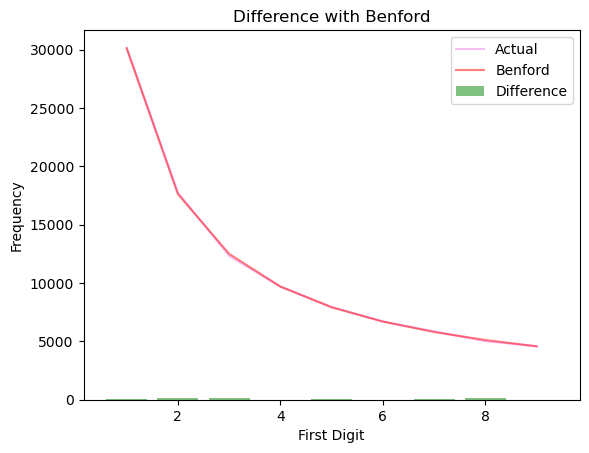

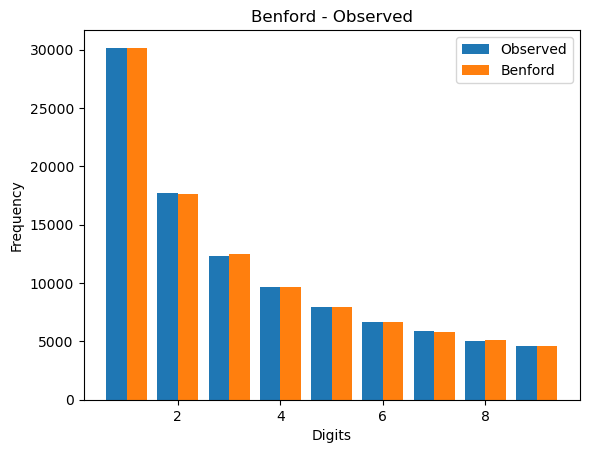

Linearity Check:
Pearson Coefficient: 0.9999999999954512, P-Value: 0.0
R-squared: 1.0000


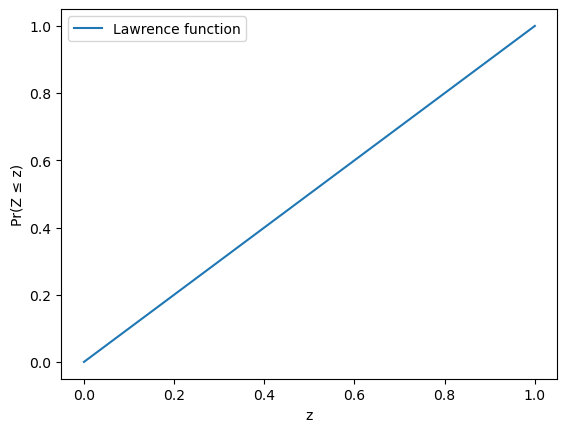

In [8]:
weibull_rv = weibull_min(c = 1, scale = 1)
data = weibull_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(weibull_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

weibull_rv = weibull_min(c = 0.3, scale = 1)
data = weibull_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(weibull_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Exponential

Chi2 Statistic: 614.4364361721172, Chi2 P-Value: 1.8418767034835939e-127
Lawrence Statistics-> c: 0.006144364361721177, m: 0.028300004336018814
MAD Statistic: 0.007817343188950141
MAD result: None
KS Statistic: 0.027730000000000032 KS P-Value: 7.802591284443768e-34
Pearson Statistic: 0.9948664612545693 Pearson P-Value: 3.1756049170897575e-08
J-Divergence: 0.00892132065680644


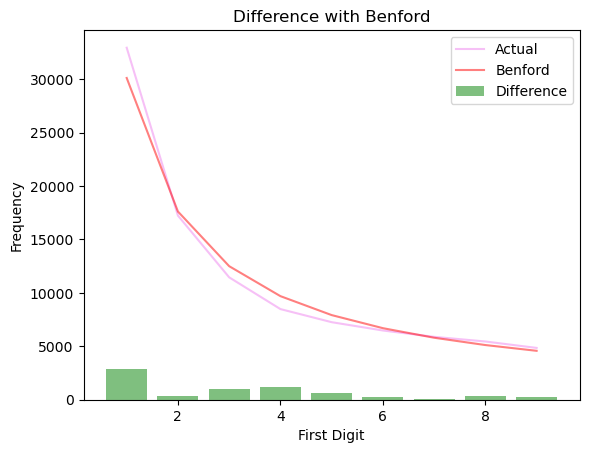

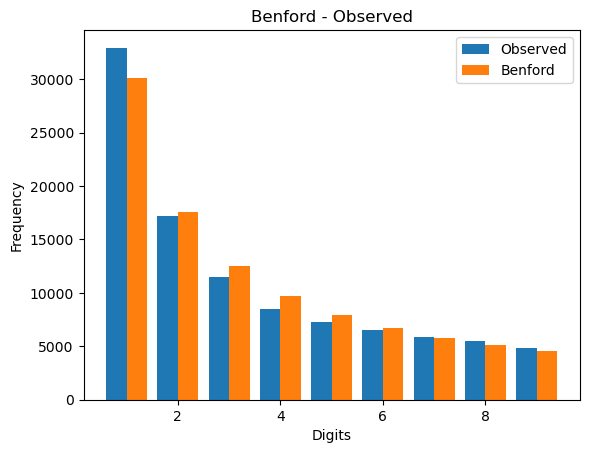

Linearity Check:
Pearson Coefficient: 0.9992911002602028, P-Value: 0.0
R-squared: 0.9986


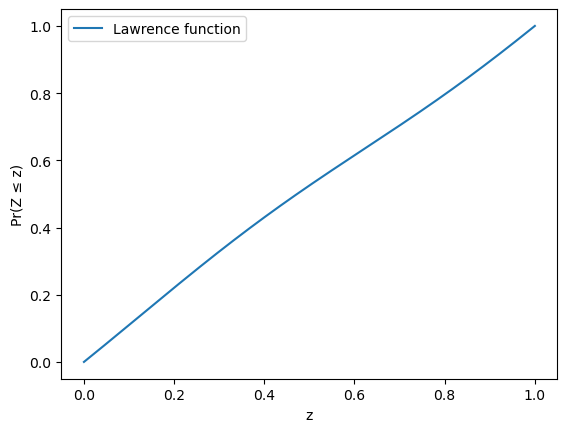

Chi2 Statistic: 569.3644221516836, Chi2 P-Value: 8.986715222257933e-118
Lawrence Statistics-> c: 0.0056936442215168356, m: 0.016081259055681224
MAD Statistic: 0.007686664739547195
MAD result: None
KS Statistic: 0.03637999999999997 KS P-Value: 6.233975453693305e-58
Pearson Statistic: 0.9975917566334908 Pearson P-Value: 2.251495466748414e-09
J-Divergence: 0.008104021665623833


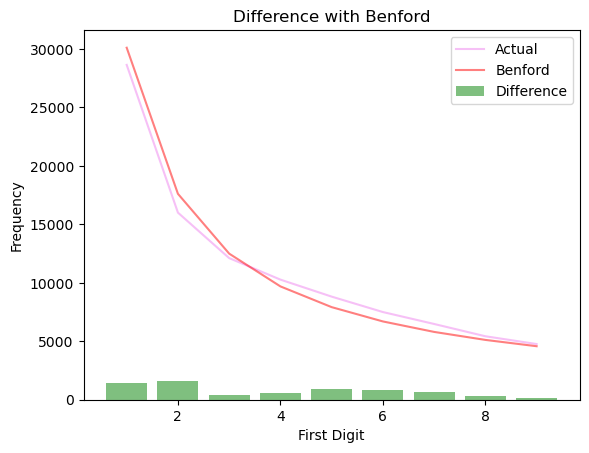

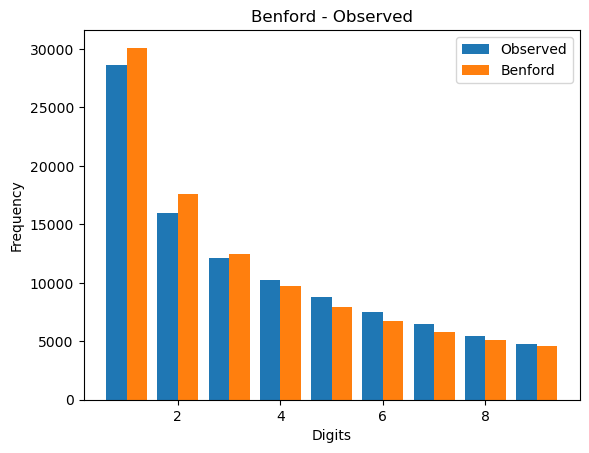

Linearity Check:
Pearson Coefficient: 0.9991016425788022, P-Value: 0.0
R-squared: 0.9982


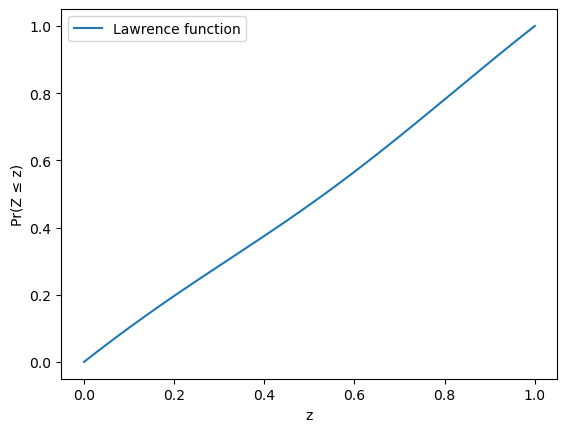

In [9]:
expon_rv = expon(scale = 1) 
data = expon_rv.rvs(size = SAMPLE_SIZE) 
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(expon_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

expon_rv = expon(scale=5)
data = expon_rv.rvs(size=SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(expon_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Lognormal

Chi2 Statistic: 127.10453186865917, Chi2 P-Value: 1.1259020201657384e-23
Lawrence Statistics-> c: 0.0012710453186865938, m: 0.007541259055681232
MAD Statistic: 0.0036802788265916492
MAD result: None
KS Statistic: 0.0107799999999999 KS P-Value: 1.7821085855519072e-05
Pearson Statistic: 0.998484356195831 Pearson P-Value: 4.4564284736820117e-10
J-Divergence: 0.0018356450893344655


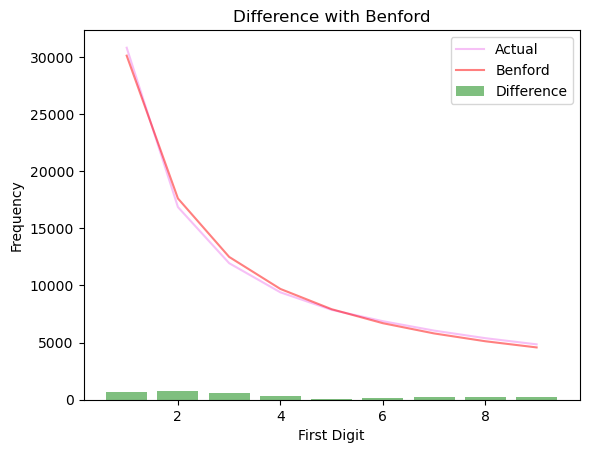

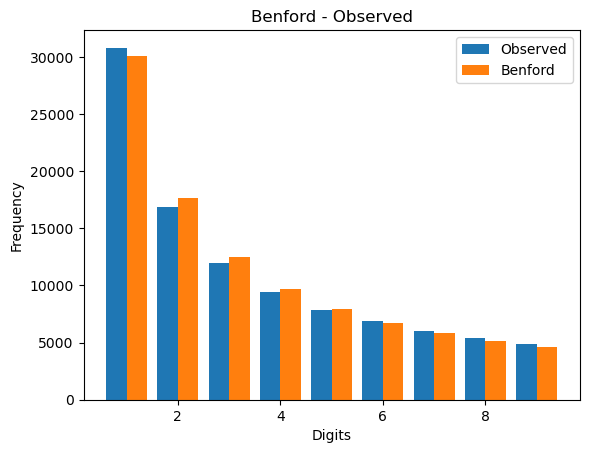

Linearity Check:
Pearson Coefficient: 0.9999282423835549, P-Value: 0.0
R-squared: 0.9999


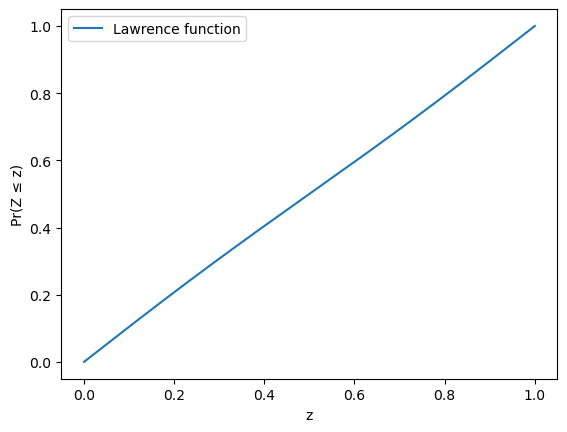

Chi2 Statistic: 87022.1722529305, Chi2 P-Value: 0.0
Lawrence Statistics-> c: 0.8702217225293049, m: 0.1879300043360188
MAD Statistic: 0.09384250104881388
MAD result: None
KS Statistic: 0.23656 KS P-Value: 0.0
Pearson Statistic: 0.6619777406852474 Pearson P-Value: 0.05209570888344133
J-Divergence: 2.2994443299351377


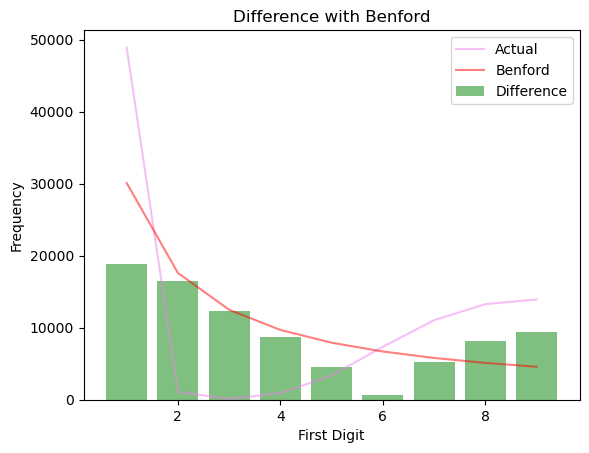

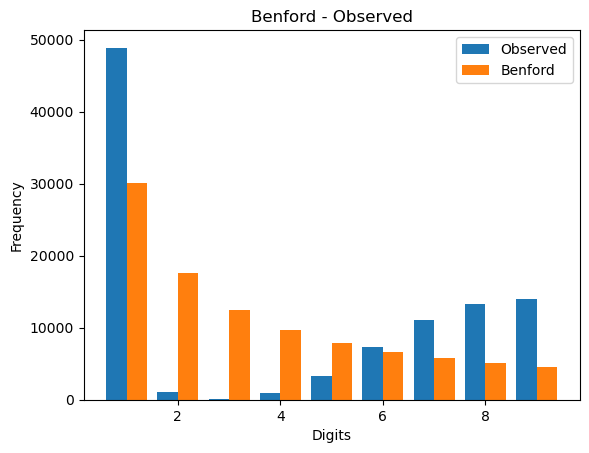

Linearity Check:
Pearson Coefficient: 0.8635057128110248, P-Value: 6.067492206445091e-299
R-squared: 0.7456


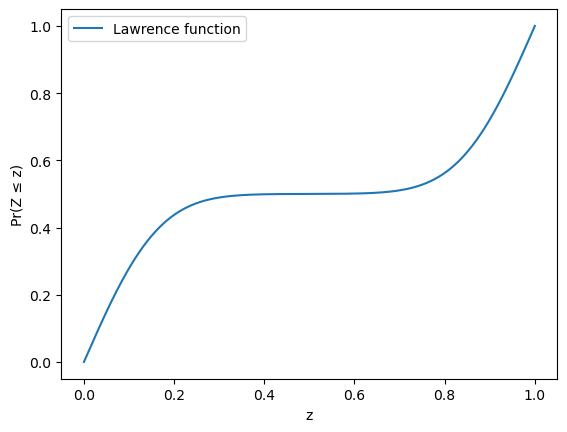

Chi2 Statistic: 158.90580920603912, Chi2 P-Value: 2.7084374124688837e-30
Lawrence Statistics-> c: 0.0015890580920603892, m: 0.01359999566398118
MAD Statistic: 0.004250832284519461
MAD result: None
KS Statistic: 0.017449999999999966 KS P-Value: 1.1769701620127212e-13
Pearson Statistic: 0.9990065990642036 Pearson P-Value: 1.0163738990849719e-10
J-Divergence: 0.002289623601943651


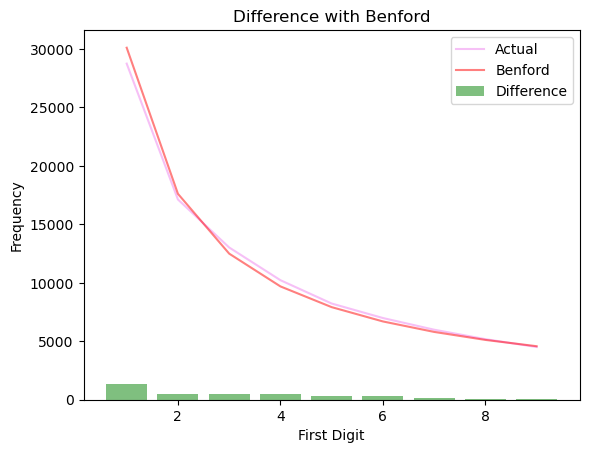

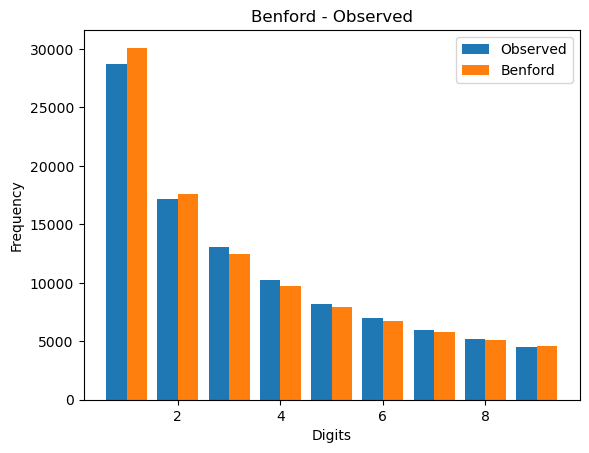

Linearity Check:
Pearson Coefficient: 0.9998350015249441, P-Value: 0.0
R-squared: 0.9997


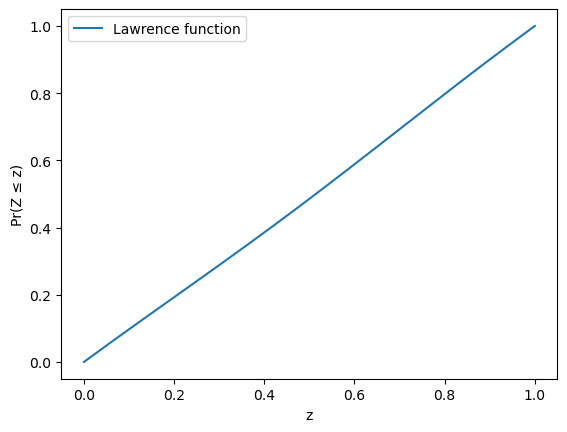

In [10]:
lognorm_rv = lognorm(s = 1, scale = 1)
data = lognorm_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(lognorm_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

lognorm_rv = lognorm(s = 0.3, scale = 1)
data = lognorm_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(lognorm_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

lognorm_rv = lognorm(s = 1, scale = 0.5)
data = lognorm_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(lognorm_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Gamma

Chi2 Statistic: 611.0693647308037, Chi2 P-Value: 9.756070310762432e-127
Lawrence Statistics-> c: 0.006110693647308032, m: 0.026320004336018776
MAD Statistic: 0.0076970633987987515
MAD result: None
KS Statistic: 0.026059999999999972 KS P-Value: 6.2401986303727616e-30
Pearson Statistic: 0.9955099850714105 Pearson P-Value: 1.9884146007660782e-08
J-Divergence: 0.008933279809864726


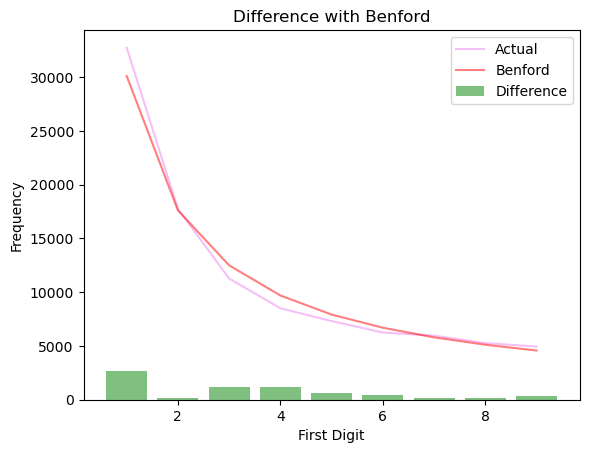

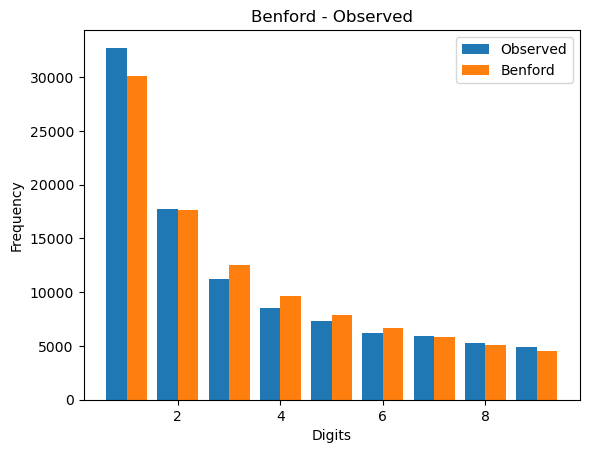

Linearity Check:
Pearson Coefficient: 0.9992911002602027, P-Value: 0.0
R-squared: 0.9986


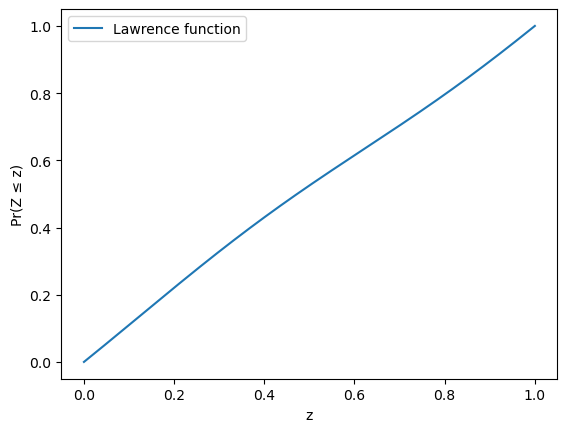

Chi2 Statistic: 17.472750360996375, Chi2 P-Value: 0.02554602329003563
Lawrence Statistics-> c: 0.0001747275036099645, m: 0.003700004336018803
MAD Statistic: 0.00135805371369022
MAD result: acceptable
KS Statistic: 0.005589999999999984 KS P-Value: 0.0875556025612313
Pearson Statistic: 0.9997510628925892 Pearson P-Value: 8.01208722118237e-13
J-Divergence: 0.0002526859017920264


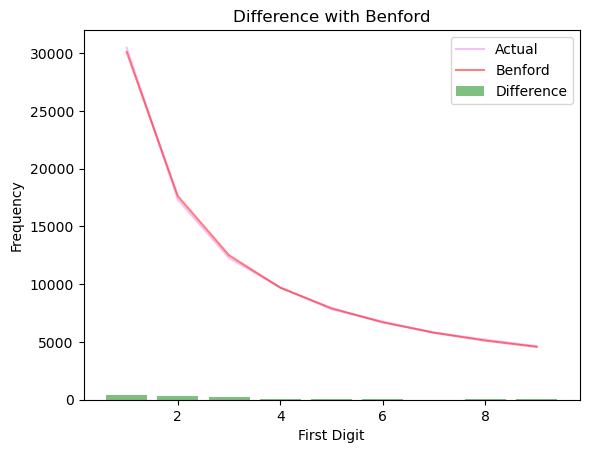

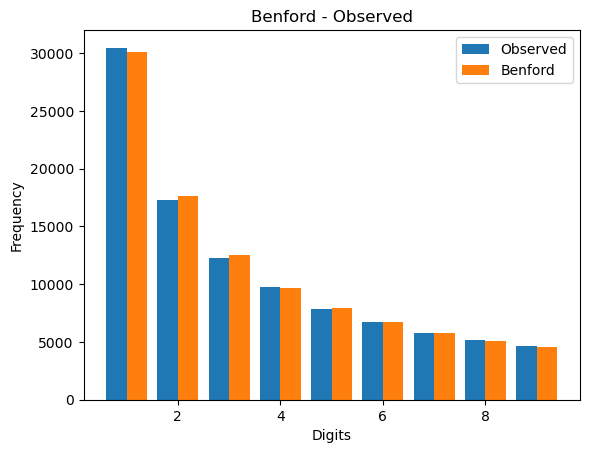

Linearity Check:
Pearson Coefficient: 0.9999877501780179, P-Value: 0.0
R-squared: 1.0000


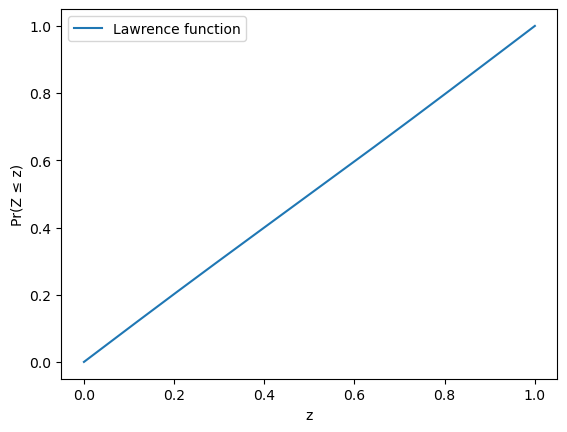

In [11]:
gamma_rv = gamma(a = 1, scale = 1)
data = gamma_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(gamma_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

gamma_rv = gamma(a = 0.3, scale = 1)
data = gamma_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(gamma_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Beta

Chi2 Statistic: 39546.62848387591, Chi2 P-Value: 0.0
Lawrence Statistics-> c: 0.3954662848387591, m: 0.18938999566398118
MAD Statistic: 0.05909777585065829
MAD result: None
KS Statistic: 0.26838000000000006 KS P-Value: 0.0
Pearson Statistic: 0.5573700220570695 Pearson P-Value: 0.11896487623939868
J-Divergence: 0.5619696294677154


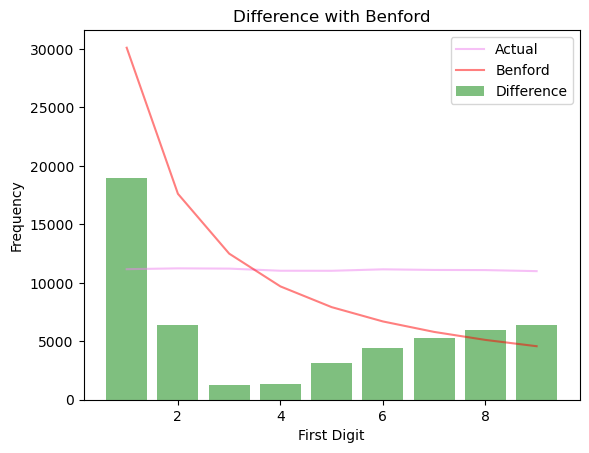

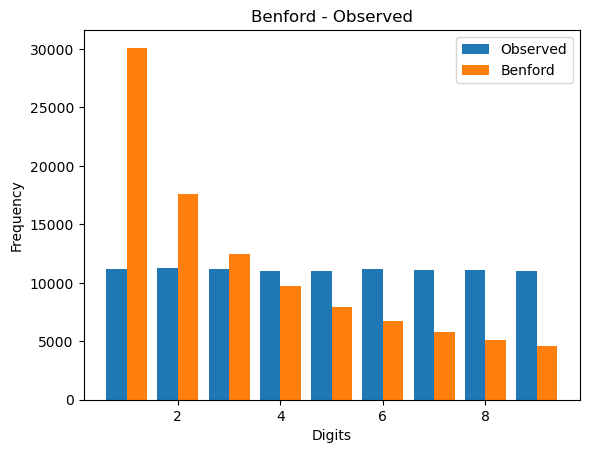

Linearity Check:
Pearson Coefficient: 0.9598678866780421, P-Value: 0.0
R-squared: 0.9213


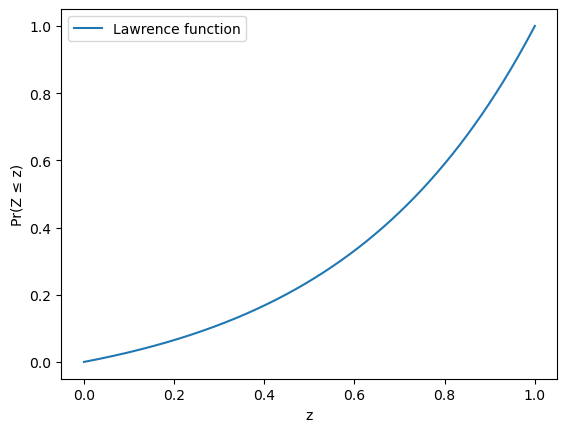

Chi2 Statistic: 158294.51426802875, Chi2 P-Value: 0.0
Lawrence Statistics-> c: 1.5829451426802879, m: 0.25353250943932487
MAD Statistic: 0.06963583341858746
MAD result: None
KS Statistic: 0.31443000000000004 KS P-Value: 0.0
Pearson Statistic: -0.028303082676274575 Pearson P-Value: 0.9423799097560686
J-Divergence: 1.00732324055355


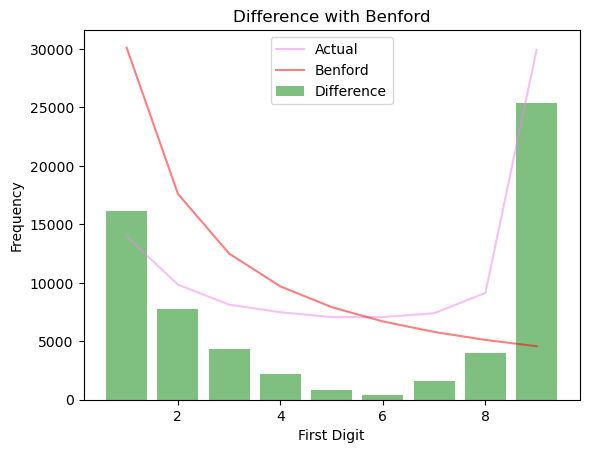

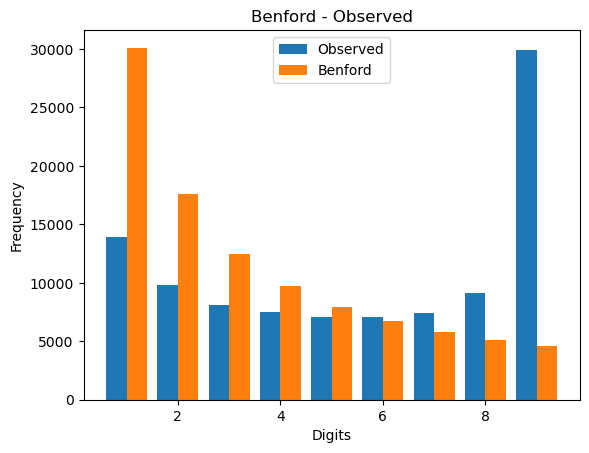

Linearity Check:
Pearson Coefficient: 0.9743149302629346, P-Value: 0.0
R-squared: 0.9493


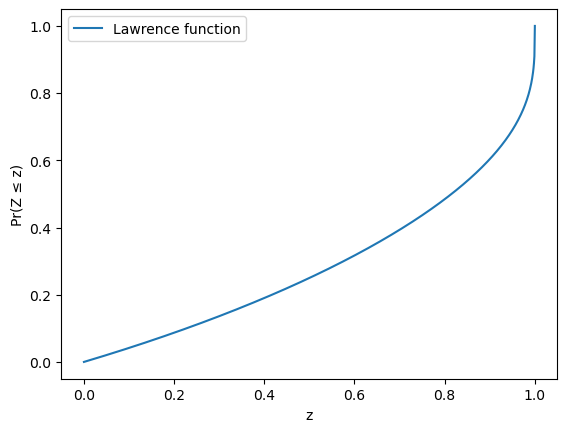

In [12]:
beta_rv = beta(a = 1, b = 1)
data = beta_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(beta_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


beta_rv = beta(a = 0.3, b = 0.3)
data = beta_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(beta_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Triangular

Chi2 Statistic: 57022.3864518504, Chi2 P-Value: 0.0
Lawrence Statistics-> c: 0.570223864518504, m: 0.2403499956639812
MAD Statistic: 0.07487972117340834
MAD result: None
KS Statistic: 0.31659000000000004 KS P-Value: 0.0
Pearson Statistic: -0.14487153392590205 Pearson P-Value: 0.709983269034418
J-Divergence: 0.9643445726346397


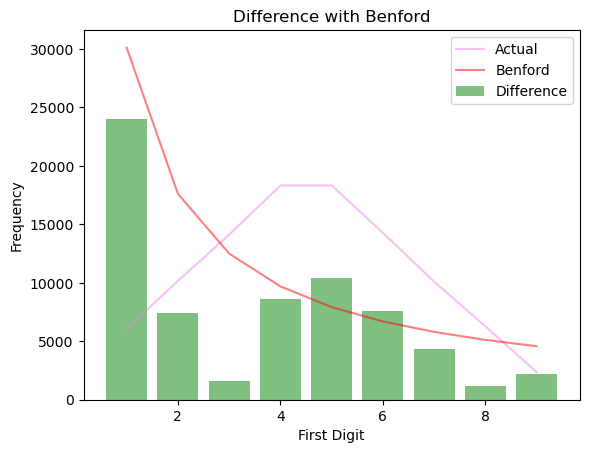

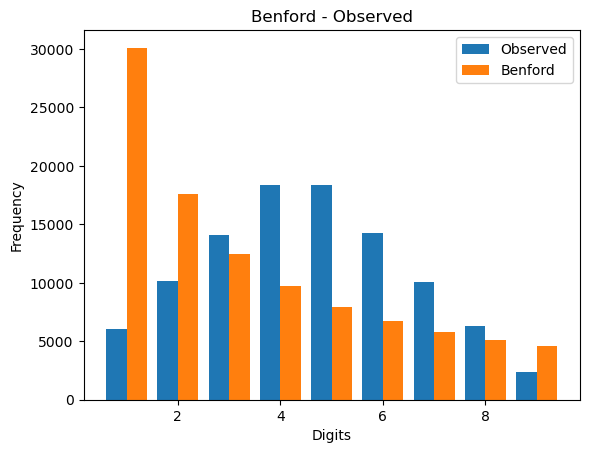

Linearity Check:
Pearson Coefficient: 0.9409639410954862, P-Value: 0.0
R-squared: 0.8854


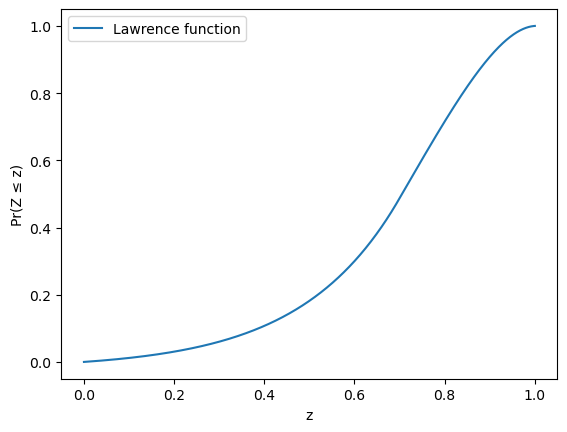

Chi2 Statistic: 8739.042195001291, Chi2 P-Value: 0.0
Lawrence Statistics-> c: 0.08739042195001293, m: 0.1096999956639812
MAD Statistic: 0.029066948383937523
MAD result: None
KS Statistic: 0.11329 KS P-Value: 0.0
Pearson Statistic: 0.8634705750174159 Pearson P-Value: 0.0027022684467861865
J-Divergence: 0.13323334790501615


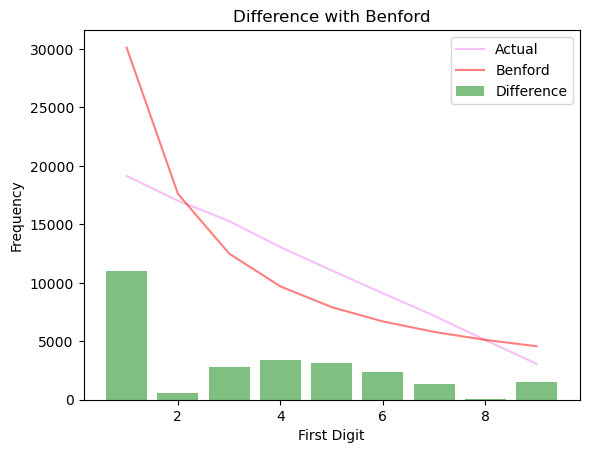

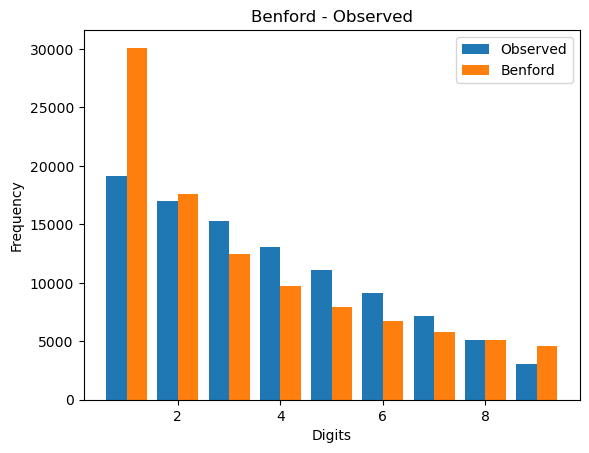

Linearity Check:
Pearson Coefficient: 0.9917444073255333, P-Value: 0.0
R-squared: 0.9836


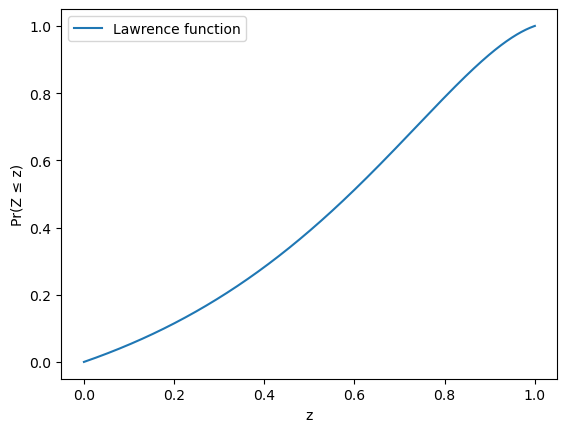

In [13]:
triang_rv = triang(c = 0.5)
data = triang_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(triang_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

triang_rv = triang(c = 0.1)
data = triang_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(triang_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

#### - Loggamma

Chi2 Statistic: 1148.2611840976083, Chi2 P-Value: 1.4434577657312342e-242
Lawrence Statistics-> c: 0.011482611840976091, m: 0.025610004336018788
MAD Statistic: 0.011235834382147206
MAD result: None
KS Statistic: 0.02638999999999997 KS P-Value: 1.1045303151769004e-30
Pearson Statistic: 0.987231846143959 Pearson P-Value: 7.648599822342001e-07
J-Divergence: 0.016658738924455095


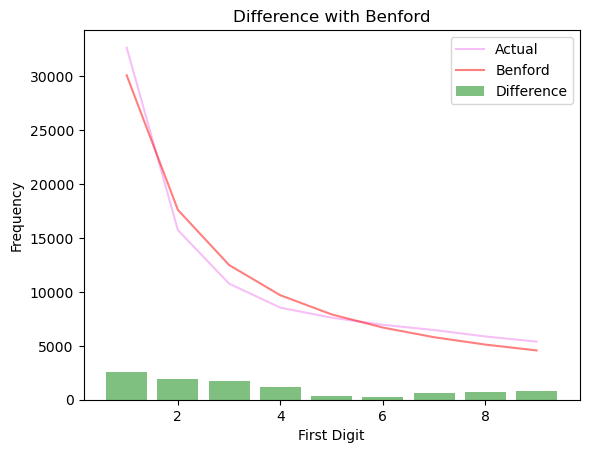

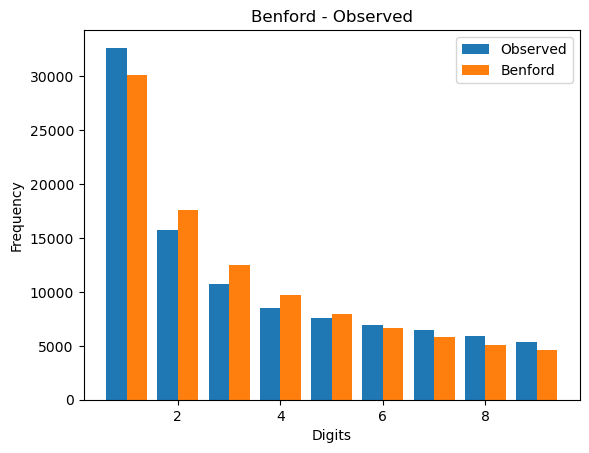

/Users/treant/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5504: RuntimeWarning: overflow encountered in exp
  return sc.gammainc(c, np.exp(x))


Linearity Check:
Pearson Coefficient: 0.9902115849421613, P-Value: 0.0
R-squared: 0.9805


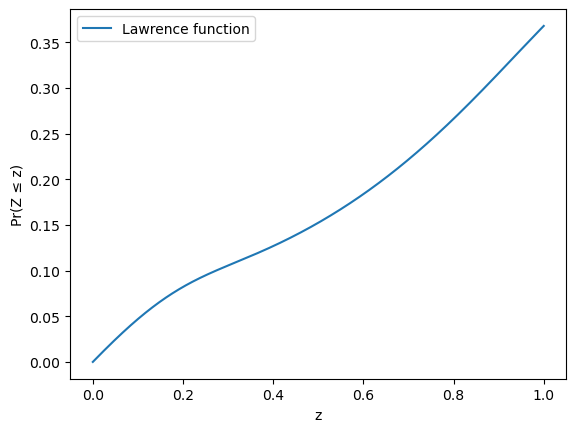

Chi2 Statistic: 1218.2520179375686, Chi2 P-Value: 1.0915569297417703e-257
Lawrence Statistics-> c: 0.01218252017937569, m: 0.042109995663981215
MAD Statistic: 0.010664726161715309
MAD result: None
KS Statistic: 0.04572999999999999 KS P-Value: 2.659749834421911e-91
Pearson Statistic: 0.9868772031219536 Pearson P-Value: 8.415415190595364e-07
J-Divergence: 0.017703546055425144


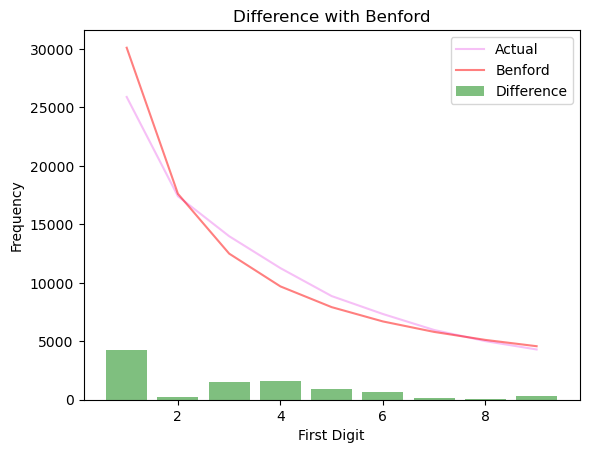

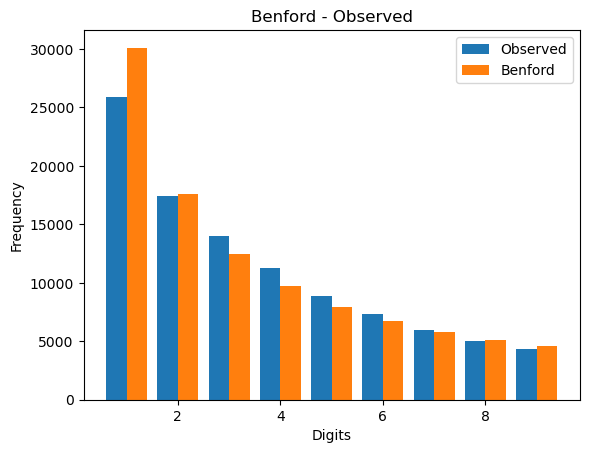

/Users/treant/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5504: RuntimeWarning: overflow encountered in exp
  return sc.gammainc(c, np.exp(x))


Linearity Check:
Pearson Coefficient: 0.9928410725746288, P-Value: 0.0
R-squared: 0.9857


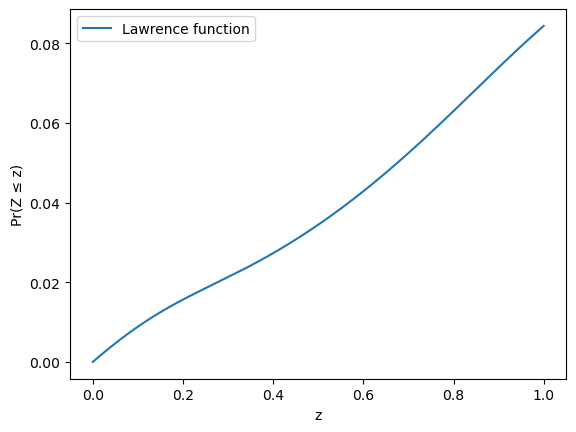

In [14]:
loggamma_rv = loggamma(c = 1)
data = loggamma_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(loggamma_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


loggamma_rv = loggamma(c = 0.3)
data = loggamma_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(loggamma_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Zipf

In [15]:
# zipf_rv = zipf(a = 1.5)
# data = zipf_rv.rvs(size = SAMPLE_SIZE)
# analyzer.set_data(data)
# analyzer.report()
# lbc = LawrenceBenfordCheck(zipf_rv.cdf, LAWRENCE_DOMAIN)
# lbc.compare_cdf_with_benford()
# 
# zipf_rv = zipf(a = 1.1)
# data = zipf_rv.rvs(size = SAMPLE_SIZE)
# analyzer.set_data(data)
# analyzer.report()
# lbc = LawrenceBenfordCheck(zipf_rv.cdf, LAWRENCE_DOMAIN)
# lbc.compare_cdf_with_benford()


#### - Burr

Chi2 Statistic: 8.846878094771762, Chi2 P-Value: 0.35537747269281855
Lawrence Statistics-> c: 8.846878094771652e-05, m: 0.0023799956639811715
MAD Statistic: 0.000719288511700183
MAD result: None
KS Statistic: 0.0024399999999999977 KS P-Value: 0.9264415542415005
Pearson Statistic: 0.9999532554216656 Pearson P-Value: 2.299199581645321e-15
J-Divergence: 0.0001266805033537274


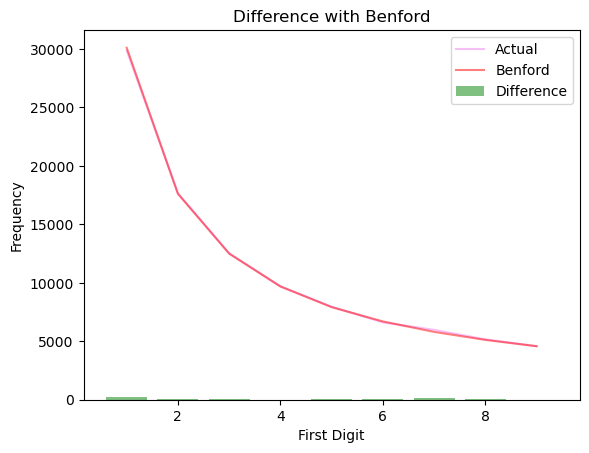

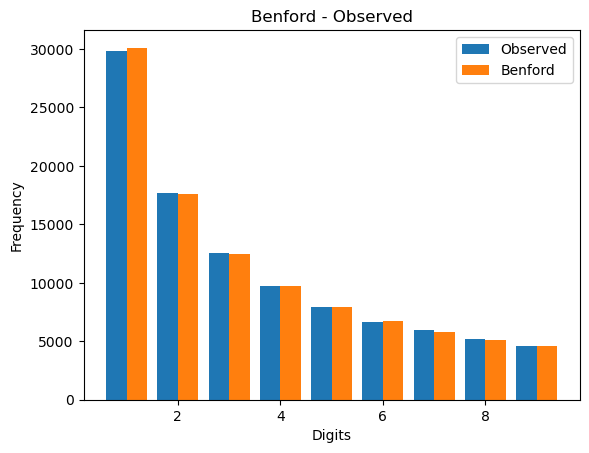

Linearity Check:
Pearson Coefficient: 0.9999987390969097, P-Value: 0.0
R-squared: 1.0000


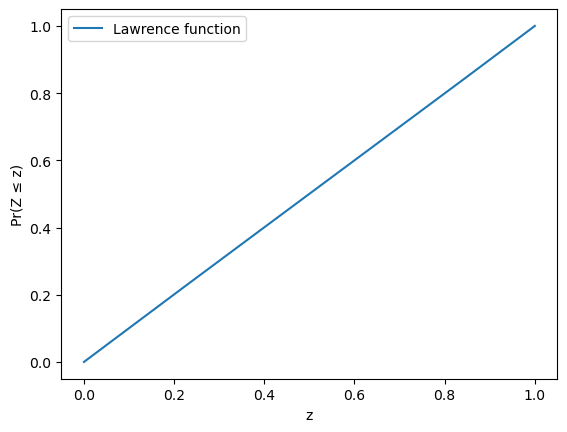

Chi2 Statistic: 10.374956982624939, Chi2 P-Value: 0.23968855556662433
Lawrence Statistics-> c: 0.00010374956982624944, m: 0.0016312460476248236
MAD Statistic: 0.0007598740449651195
MAD result: None
KS Statistic: 0.0016699999999999493 KS P-Value: 0.9990024224605631
Pearson Statistic: 0.9999326907292226 Pearson P-Value: 8.23703146326774e-15
J-Divergence: 0.00015001873616971996


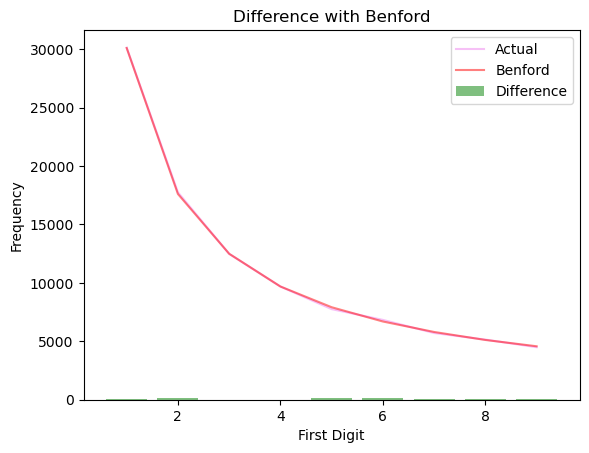

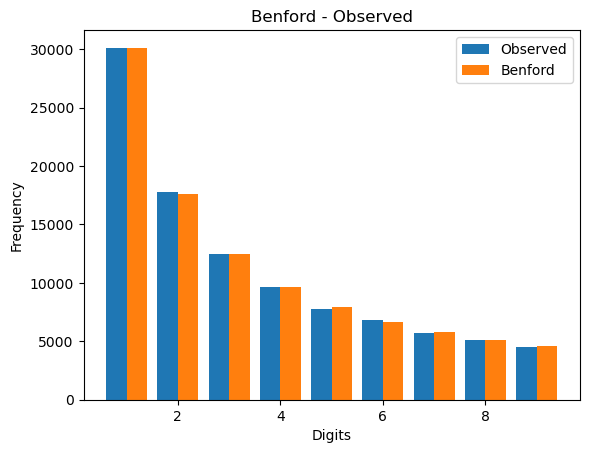

Linearity Check:
Pearson Coefficient: 0.9999999071701045, P-Value: 0.0
R-squared: 1.0000


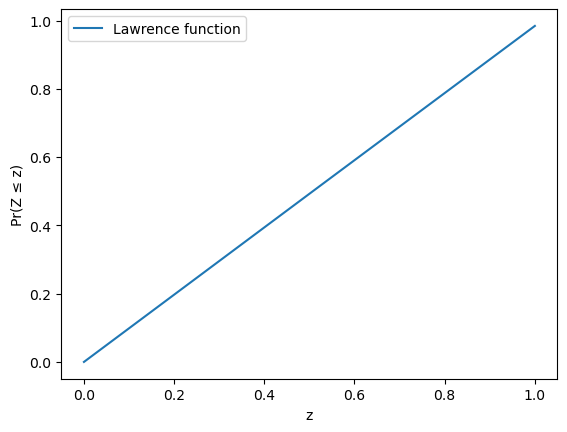

In [16]:
burr_rv = burr(c = 1, d = 1)
data = burr_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(burr_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

burr_rv = burr(c = 0.3, d = 0.3)
data = burr_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(burr_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Inverse Gamma

Chi2 Statistic: 534.5200272556647, Chi2 P-Value: 2.741483106413939e-110
Lawrence Statistics-> c: 0.005345200272556653, m: 0.017931259055681242
MAD Statistic: 0.006935553628436087
MAD result: None
KS Statistic: 0.02756000000000003 KS P-Value: 1.998165474508807e-33
Pearson Statistic: 0.9962776658533155 Pearson P-Value: 1.0323288380770418e-08
J-Divergence: 0.00769705031390998


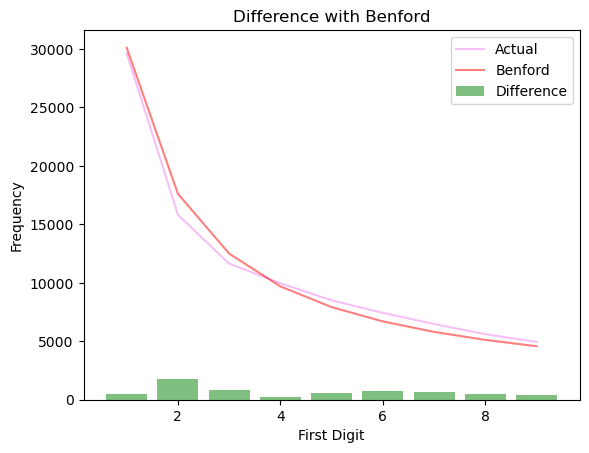

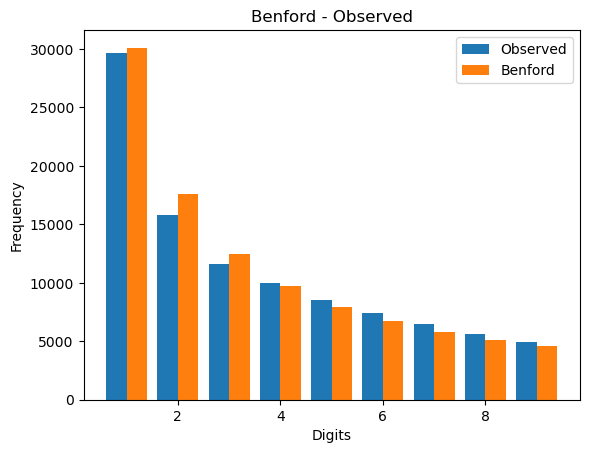

Linearity Check:
Pearson Coefficient: 0.9992911002602028, P-Value: 0.0
R-squared: 0.9986


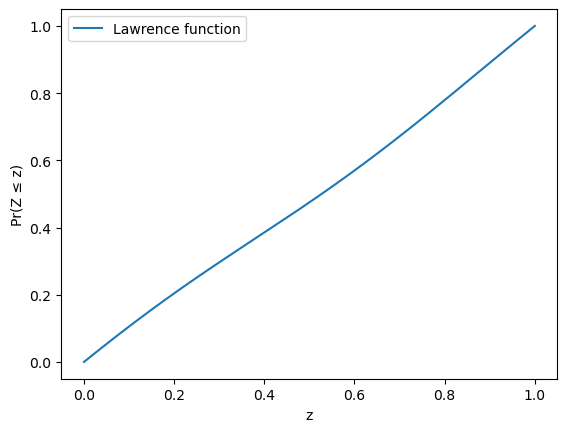

Chi2 Statistic: 29.539131153539252, Chi2 P-Value: 0.0002549140461413677
Lawrence Statistics-> c: 0.0002953913115353945, m: 0.004710004336018814
MAD Statistic: 0.0017466685937861351
MAD result: acceptable
KS Statistic: 0.0050100000000000144 KS P-Value: 0.16190636437617212
Pearson Statistic: 0.9996143618710046 Pearson P-Value: 3.706842139888687e-12
J-Divergence: 0.000426548363241674


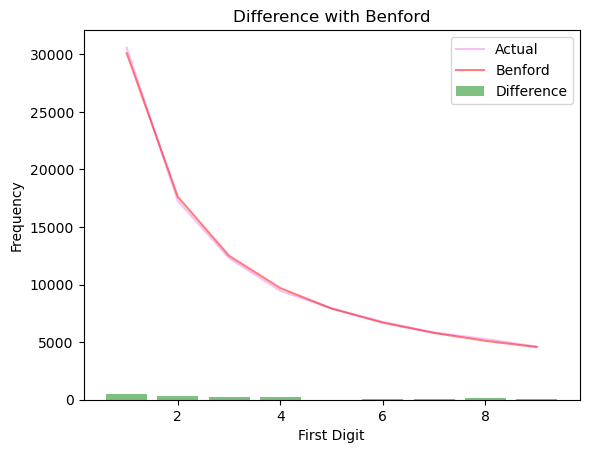

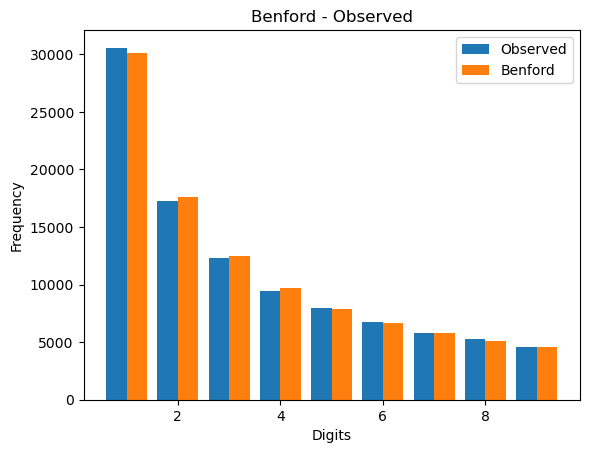

Linearity Check:
Pearson Coefficient: 0.999987750076683, P-Value: 0.0
R-squared: 1.0000


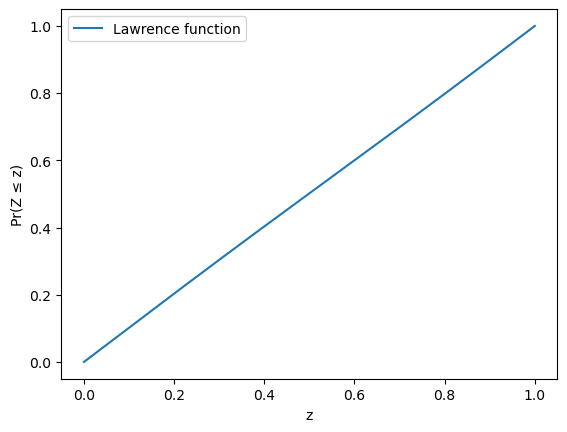

In [17]:
invgamma_rv = invgamma(a = 1)
data = invgamma_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(invgamma_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


invgamma_rv = invgamma(a = 0.3)
data = invgamma_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(invgamma_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Levy

Chi2 Statistic: 71.53767202739621, Chi2 P-Value: 2.426947407351307e-12
Lawrence Statistics-> c: 0.0007153767202739598, m: 0.009379995663981178
MAD Statistic: 0.0025025010488138747
MAD result: None
KS Statistic: 0.013749999999999984 KS P-Value: 1.2185971875788883e-08
Pearson Statistic: 0.9996605997314861 Pearson P-Value: 2.3707533212485357e-12
J-Divergence: 0.001027714303643755


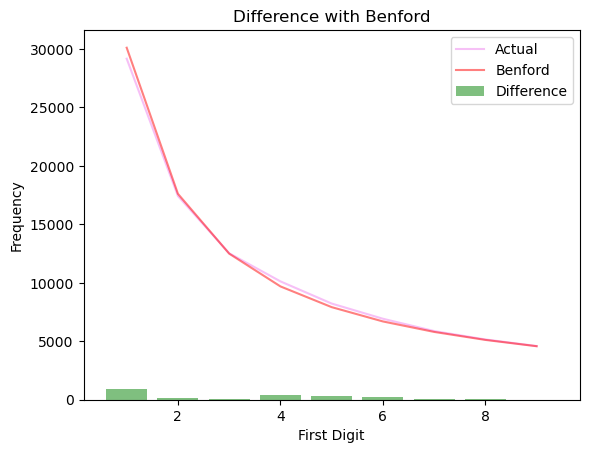

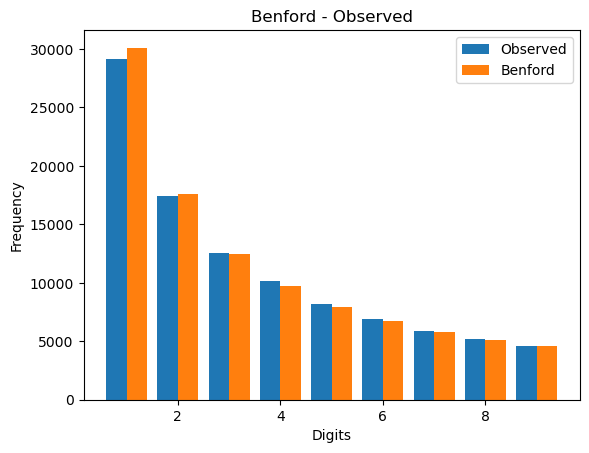

Linearity Check:
Pearson Coefficient: 0.9998939471736836, P-Value: 0.0
R-squared: 0.9998


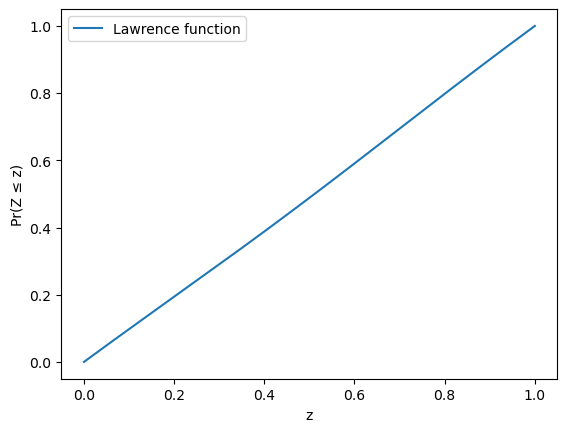

Chi2 Statistic: 91.07119905567646, Chi2 P-Value: 2.818090350882146e-16
Lawrence Statistics-> c: 0.0009107119905567673, m: 0.009320004336018817
MAD Statistic: 0.002973767922160968
MAD result: None
KS Statistic: 0.016230000000000022 KS P-Value: 7.175212331446005e-12
Pearson Statistic: 0.9994648635169091 Pearson P-Value: 1.1666404594816843e-11
J-Divergence: 0.0013238720501609347


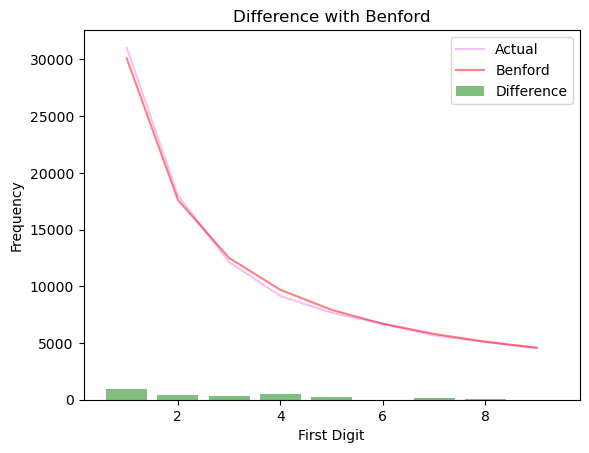

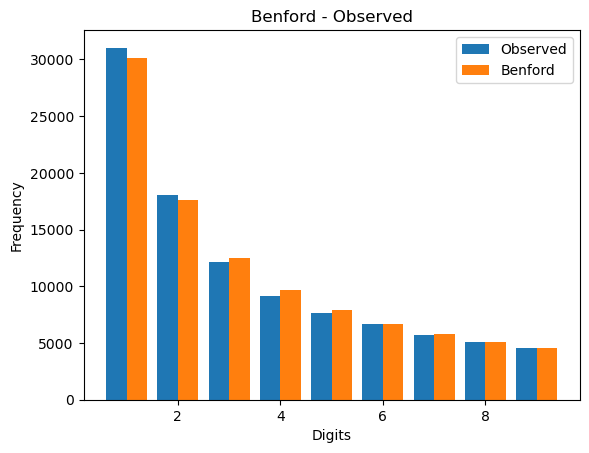

Linearity Check:
Pearson Coefficient: 0.9998994426718586, P-Value: 0.0
R-squared: 0.9998


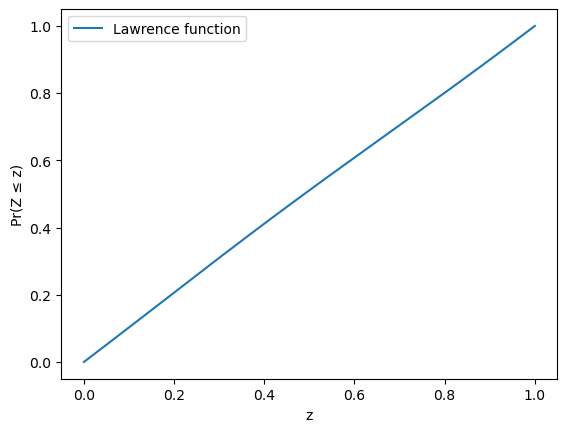

In [18]:
levy_rv = levy()
data = levy_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(levy_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

levy_rv = levy(loc = 0, scale = 0.3)
data = levy_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(levy_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

#### - Inverse Gaussian

Chi2 Statistic: 445.74782028805936, Chi2 P-Value: 3.012839107314908e-91
Lawrence Statistics-> c: 0.004457478202880593, m: 0.024949995663981206
MAD Statistic: 0.006933054506741686
MAD result: None
KS Statistic: 0.029870000000000008 KS P-Value: 3.4385679075615035e-39
Pearson Statistic: 0.9975469819216319 Pearson P-Value: 2.401338986515146e-09
J-Divergence: 0.006452661594047542


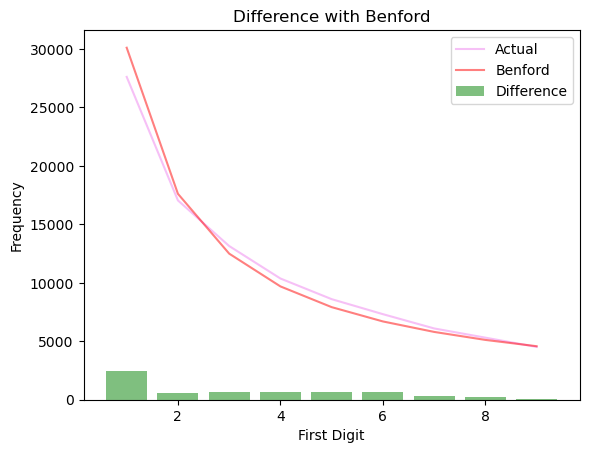

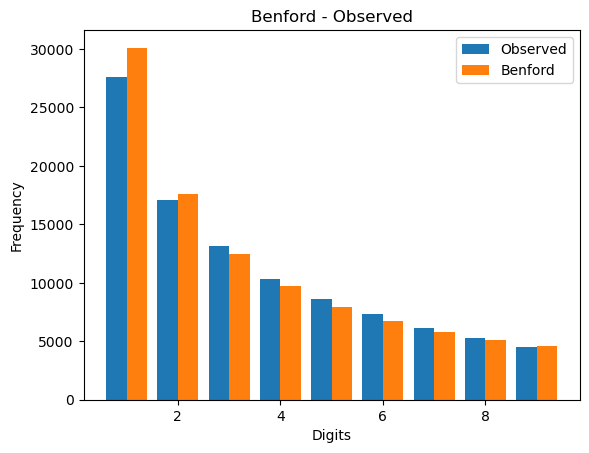

Linearity Check:
Pearson Coefficient: 0.9993351589602906, P-Value: 0.0
R-squared: 0.9987


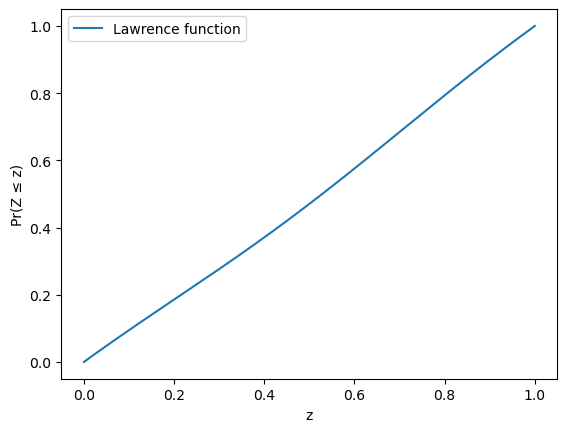

Chi2 Statistic: 21696.847344618105, Chi2 P-Value: 0.0
Lawrence Statistics-> c: 0.216968473446181, m: 0.12131874094431877
MAD Statistic: 0.0418177758506583
MAD result: None
KS Statistic: 0.16673000000000004 KS P-Value: 0.0
Pearson Statistic: 0.8940688444566794 Pearson P-Value: 0.0011468944516111511
J-Divergence: 0.36287721990429794


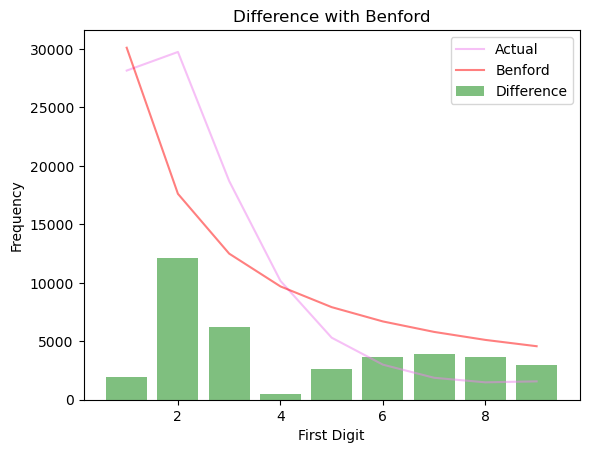

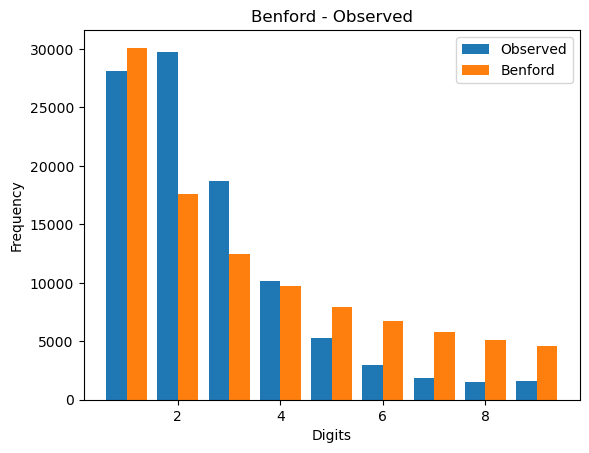

Linearity Check:
Pearson Coefficient: 0.9848404806595547, P-Value: 0.0
R-squared: 0.9699


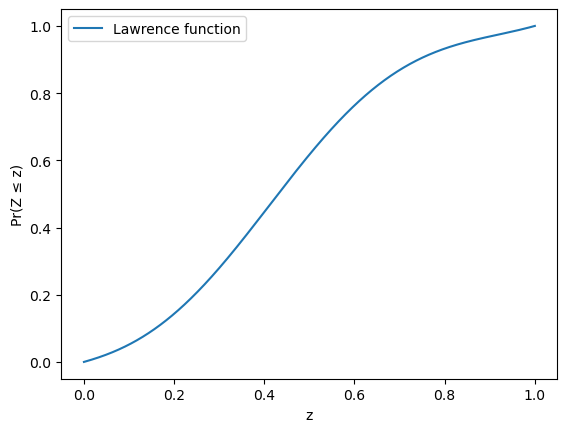

In [19]:
invgauss_rv = invgauss(mu = 1)
data = invgauss_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(invgauss_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

invgauss_rv = invgauss(mu = 0.3)
data = invgauss_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(invgauss_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

#### - Inverse Weibull

Chi2 Statistic: 618.050867967282, Chi2 P-Value: 3.076192857036272e-128
Lawrence Statistics-> c: 0.006180508679672821, m: 0.021691259055681228
MAD Statistic: 0.006924442517324975
MAD result: None
KS Statistic: 0.033440000000000025 KS P-Value: 5.1905955274975444e-49
Pearson Statistic: 0.9951338259292208 Pearson P-Value: 2.634130847577705e-08
J-Divergence: 0.008957694607445027


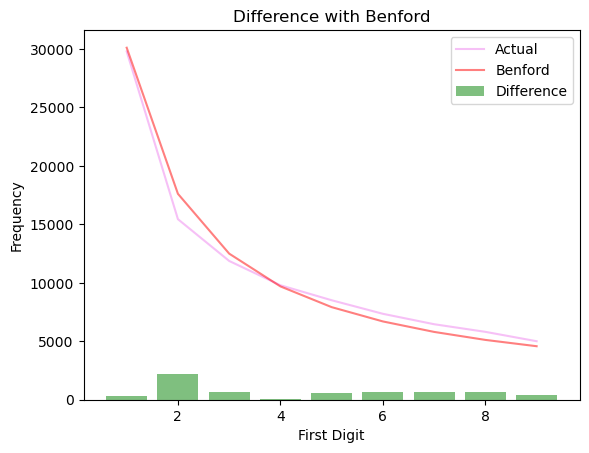

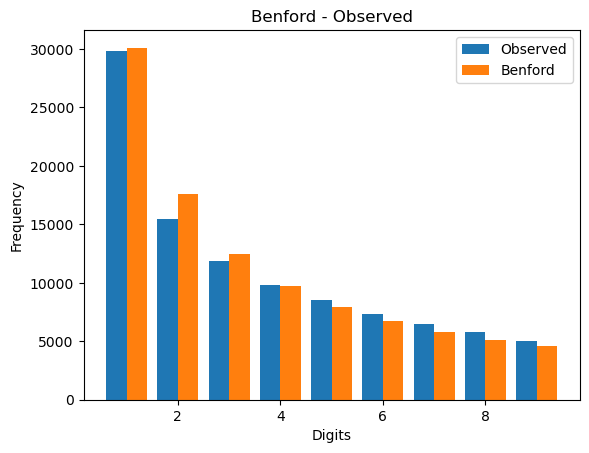

Linearity Check:
Pearson Coefficient: 0.999291100260203, P-Value: 0.0
R-squared: 0.9986


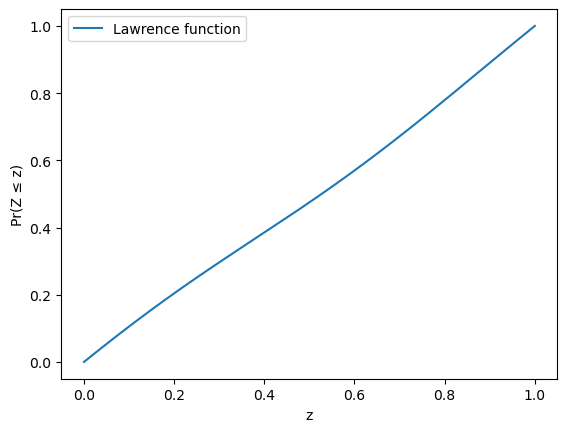

Chi2 Statistic: 2.804077423372066, Chi2 P-Value: 0.9460445620049803
Lawrence Statistics-> c: 2.8040774233721242e-05, m: 0.0021100043360188225
MAD Statistic: 0.0004762699345345761
MAD result: None
KS Statistic: 0.0023900000000000032 KS P-Value: 0.936929201385114
Pearson Statistic: 0.9999730497531636 Pearson P-Value: 3.345763832272621e-16
J-Divergence: 4.0452065056421653e-05


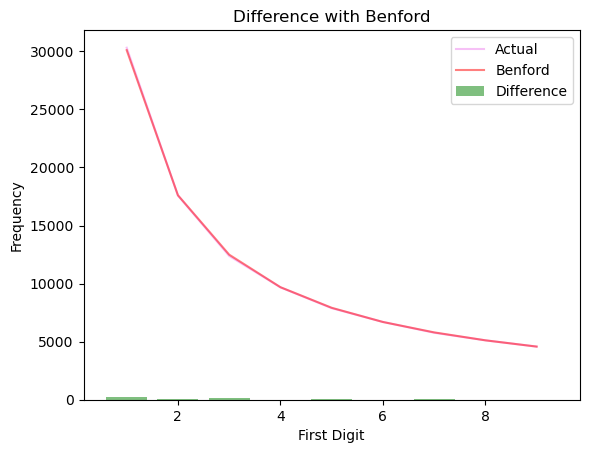

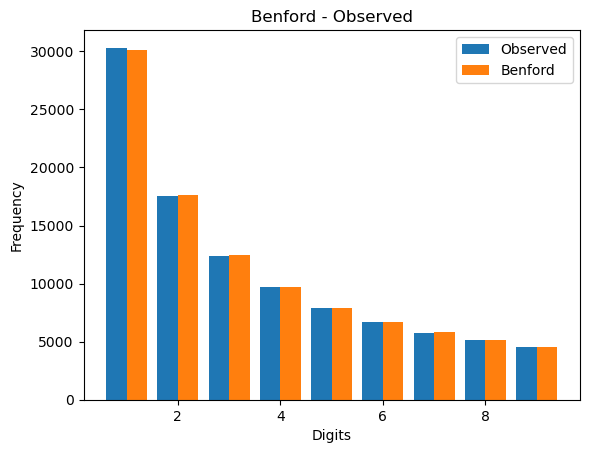

Linearity Check:
Pearson Coefficient: 0.99999999999534, P-Value: 0.0
R-squared: 1.0000


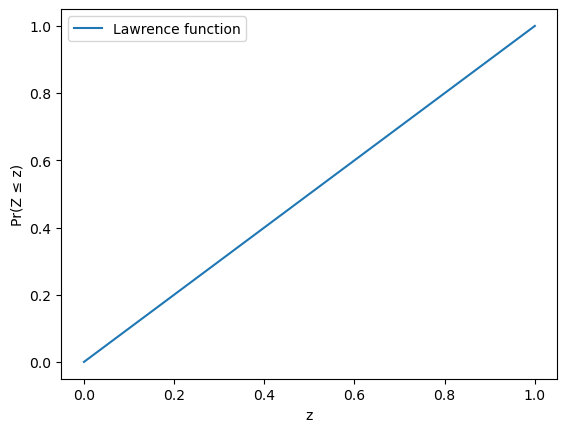

In [20]:
invweibull_rv = invweibull(c = 1)
data = invweibull_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(invweibull_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

invweibull_rv = invweibull(c = 0.3)
data = invweibull_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(invweibull_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - Cauchy

Chi2 Statistic: 148.63348629742163, Chi2 P-Value: 3.7792318311174783e-28
Lawrence Statistics-> c: 0.0014863348629742179, m: 0.007221259055681245
MAD Statistic: 0.003835557482675023
MAD result: None
KS Statistic: 0.011619999999999964 KS P-Value: 2.7131914324273095e-06
Pearson Statistic: 0.9984320622649419 Pearson P-Value: 5.017942394369637e-10
J-Divergence: 0.002139405533869557


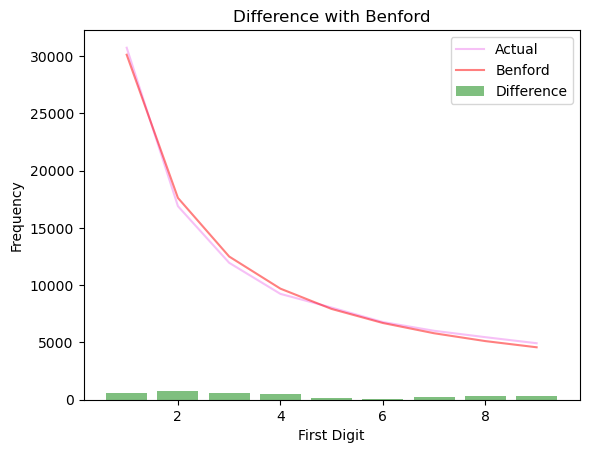

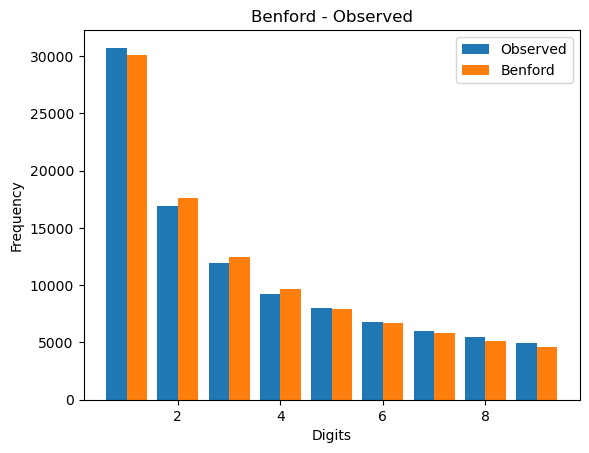

Linearity Check:
Pearson Coefficient: 0.9999075854369182, P-Value: 0.0
R-squared: 0.9998


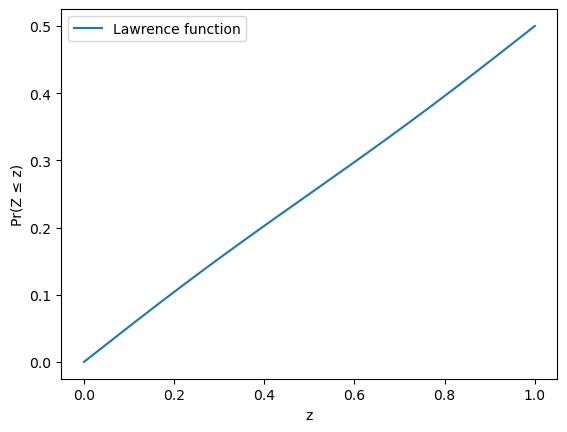

Chi2 Statistic: 169.50748535236843, Chi2 P-Value: 1.6357003634742148e-32
Lawrence Statistics-> c: 0.0016950748535236827, m: 0.009828740944318765
MAD Statistic: 0.004042220295102756
MAD result: None
KS Statistic: 0.010060000000000069 KS P-Value: 7.995054331258689e-05
Pearson Statistic: 0.9980223609517158 Pearson P-Value: 1.130358826710615e-09
J-Divergence: 0.0024432180034249917


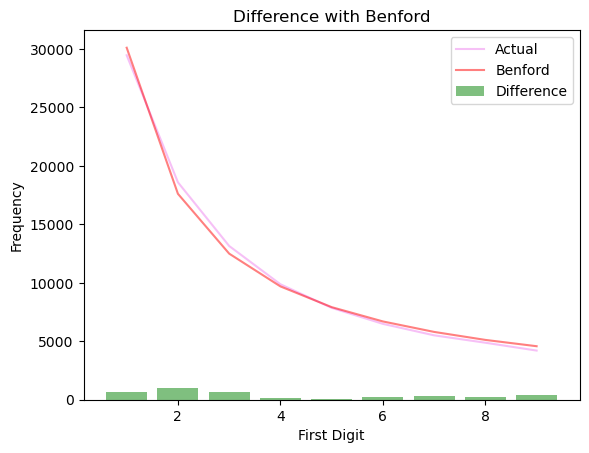

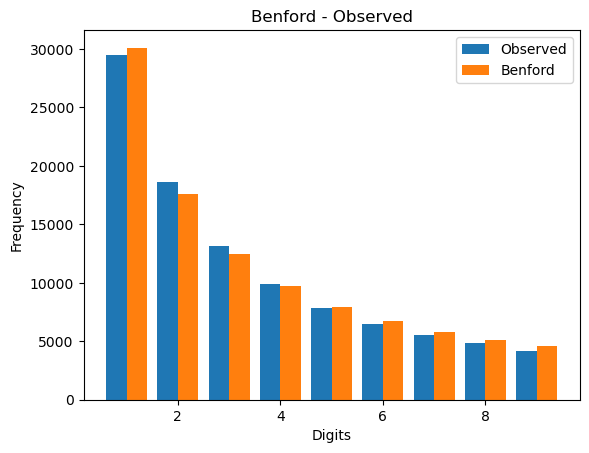

Linearity Check:
Pearson Coefficient: 0.9999089462071126, P-Value: 0.0
R-squared: 0.9998


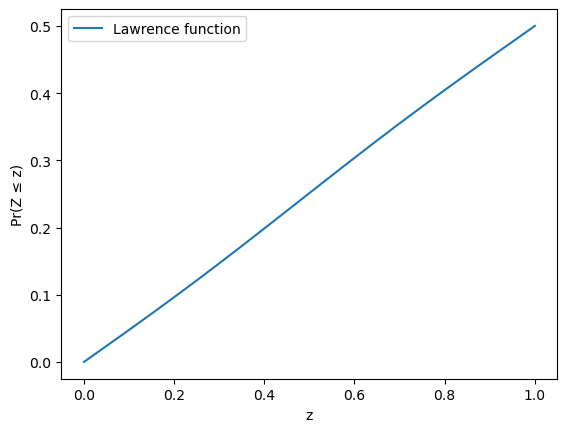

In [21]:
cauchy_rv = cauchy()
data = cauchy_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(cauchy_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

cauchy_rv = cauchy(loc = 0, scale = 0.3)
data = cauchy_rv.rvs(size = SAMPLE_SIZE)
analyzer.set_data(data)
analyzer.report()
lbc = LawrenceBenfordCheck(cauchy_rv.cdf, LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - ErdosReyni Network Degree Distribution

Chi2 Statistic: 5906.462589623935, Chi2 P-Value: 0.0
Lawrence Statistics-> c: 5.906462589623935, m: 0.43905321036938677
MAD Statistic: 0.18974932540483602
MAD result: None
KS Statistic: 0.703 KS P-Value: 1.913210671452109e-237
Pearson Statistic: -0.2622024814301216 Pearson P-Value: 0.4955091857119542
J-Divergence: nan


/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:148: RuntimeWarning: divide by zero encountered in log2
  first_digits_probes[i] * np.log2(first_digits_probes[i] / benford_probes[i]) +
/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:148: RuntimeWarning: invalid value encountered in scalar multiply
  first_digits_probes[i] * np.log2(first_digits_probes[i] / benford_probes[i]) +
/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  benford_probes[i] * np.log2(benford_probes[i] / first_digits_probes[i])


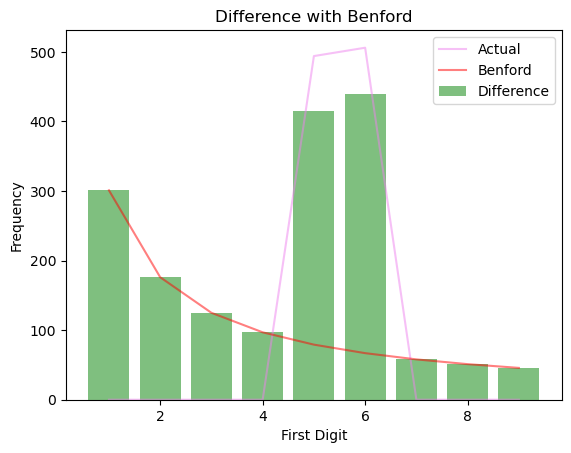

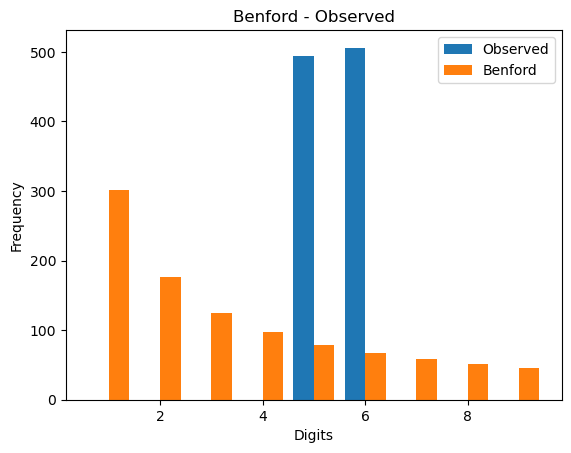

Linearity Check:
Pearson Coefficient: 0.733189669783108, P-Value: 2.4888243311063823e-169
R-squared: 0.5376


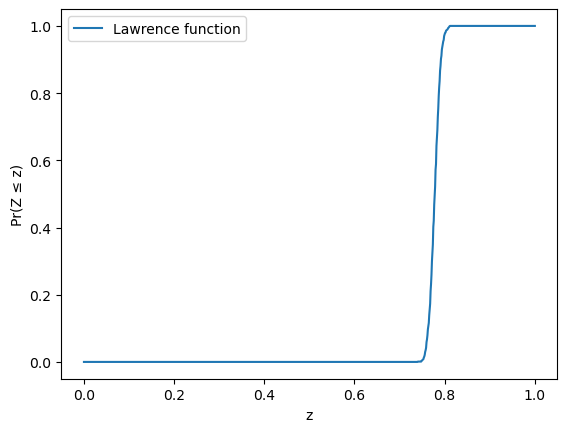

Chi2 Statistic: 169.50748535236843, Chi2 P-Value: 1.6357003634742148e-32
Lawrence Statistics-> c: 0.0016950748535236827, m: 0.009828740944318765
MAD Statistic: 0.004042220295102756
MAD result: None
KS Statistic: 0.012530000000000041 KS P-Value: 3.011147004994541e-07
Pearson Statistic: 0.9980223609517158 Pearson P-Value: 1.130358826710615e-09
J-Divergence: 0.0024432180034249917


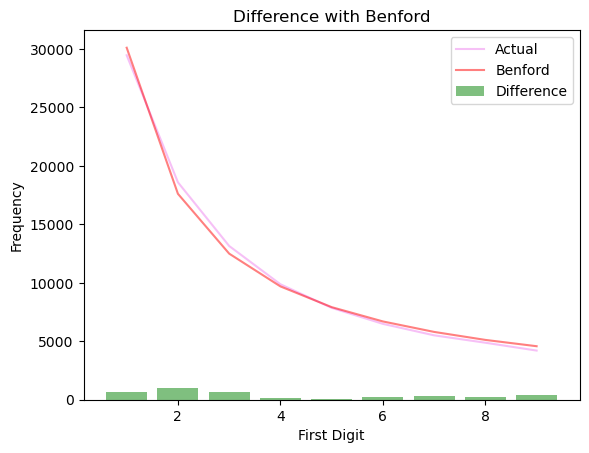

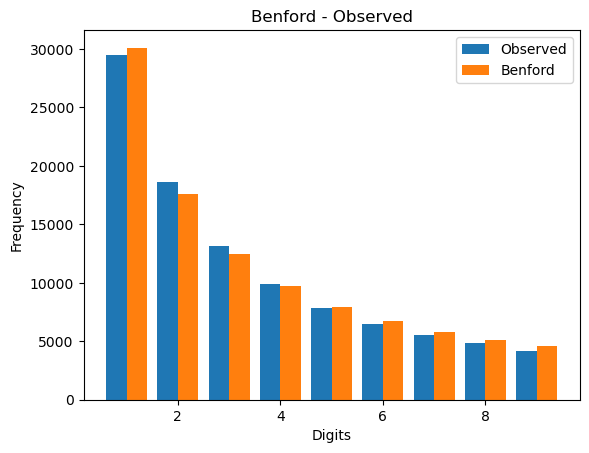

Linearity Check:
Pearson Coefficient: 0.8845902253025528, P-Value: 0.0
R-squared: 0.7825


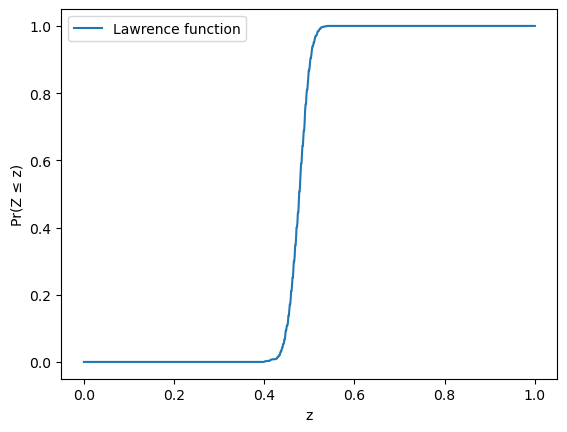

In [22]:
G = nx.erdos_renyi_graph(1000, 0.6)
degrees = [G.degree(n) for n in G.nodes()]
analyzer.set_data(degrees)
analyzer.report()
dist = Distribution(degrees)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

G = nx.erdos_renyi_graph(1000, 0.3)
degrees = [G.degree(n) for n in G.nodes]
analyzer.set_data(data)
analyzer.report()
dist = Distribution(degrees)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - BarabasiAlbert Network Degree Distribution

Chi2 Statistic: 1074.9751876892087, Chi2 P-Value: 9.715927298259723e-227
Lawrence Statistics-> c: 1.0749751876892089, m: 0.2730612633917001
MAD Statistic: 0.0953266676302264
MAD result: None
KS Statistic: 0.416 KS P-Value: 7.105707649012374e-78
Pearson Statistic: 0.05664564326038089 Pearson P-Value: 0.8849105639948731
J-Divergence: 1.6061823525067587


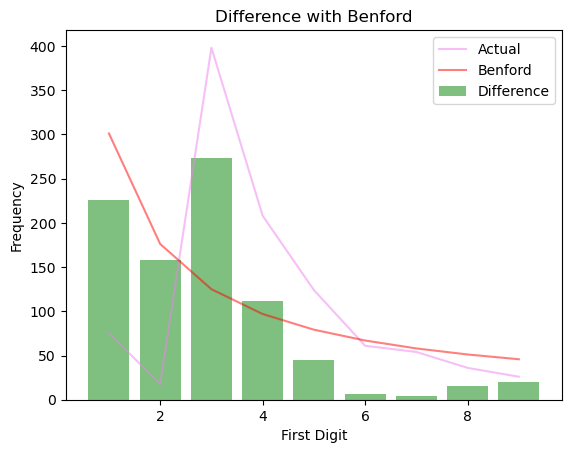

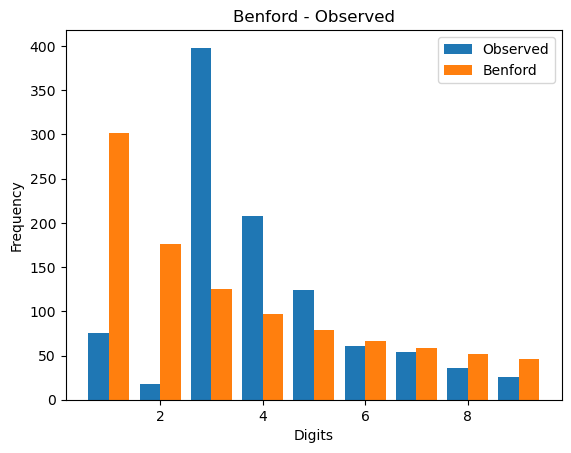

Linearity Check:
Pearson Coefficient: 0.9515732846330316, P-Value: 0.0
R-squared: 0.9055


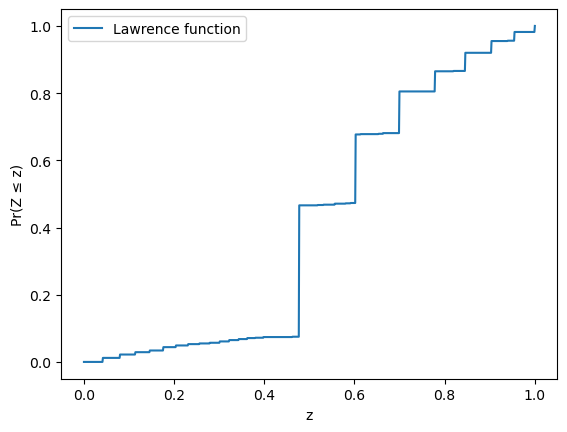

Chi2 Statistic: 1208.3056484783947, Chi2 P-Value: 1.5388975610357754e-255
Lawrence Statistics-> c: 1.208305648478395, m: 0.1988187539523752
MAD Statistic: 0.09866000096355974
MAD result: None
KS Statistic: 0.432 KS P-Value: 3.677996330485201e-84
Pearson Statistic: 0.10518505916500583 Pearson P-Value: 0.7876845883305301
J-Divergence: 1.7513112522875496


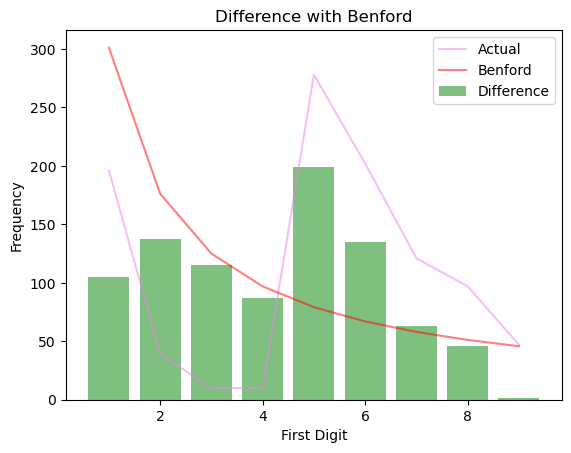

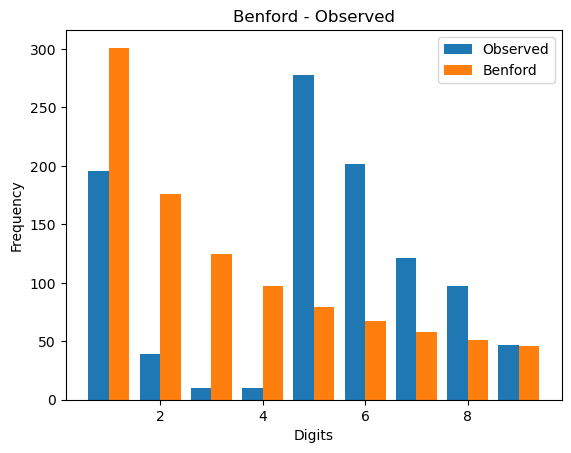

Linearity Check:
Pearson Coefficient: 0.891559074397712, P-Value: 0.0
R-squared: 0.7949


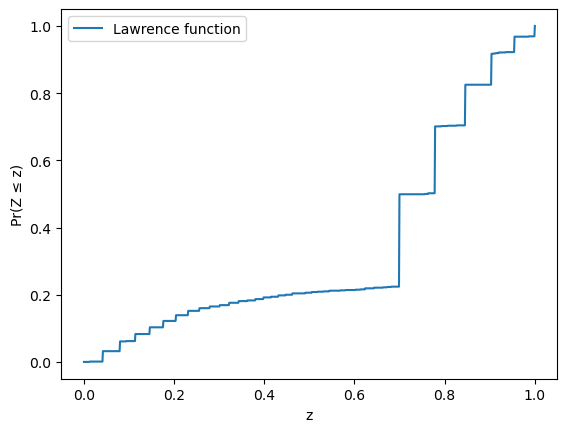

In [23]:
G = nx.barabasi_albert_graph(1000, 3)
degrees = [G.degree(n) for n in G.nodes()]
analyzer.set_data(degrees)
analyzer.report()
dist = Distribution(degrees)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

G = nx.barabasi_albert_graph(1000, 5)
degrees = [G.degree(n) for n in G.nodes()]
analyzer.set_data(degrees)
analyzer.report()
dist = Distribution(degrees)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


#### - WattsStrogatz Network Degree Distribution

Chi2 Statistic: 866.235200314253, Chi2 P-Value: 1.081668271379512e-181
Lawrence Statistics-> c: 0.8662352003142528, m: 0.30190874094431874
MAD Statistic: 0.0804377787413375
MAD result: None
KS Statistic: 0.324 KS P-Value: 7.969763456935227e-47
Pearson Statistic: 0.7729741338380841 Pearson P-Value: 0.014582870008385164
J-Divergence: nan


/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:148: RuntimeWarning: divide by zero encountered in log2
  first_digits_probes[i] * np.log2(first_digits_probes[i] / benford_probes[i]) +
/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:148: RuntimeWarning: invalid value encountered in scalar multiply
  first_digits_probes[i] * np.log2(first_digits_probes[i] / benford_probes[i]) +
/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  benford_probes[i] * np.log2(benford_probes[i] / first_digits_probes[i])


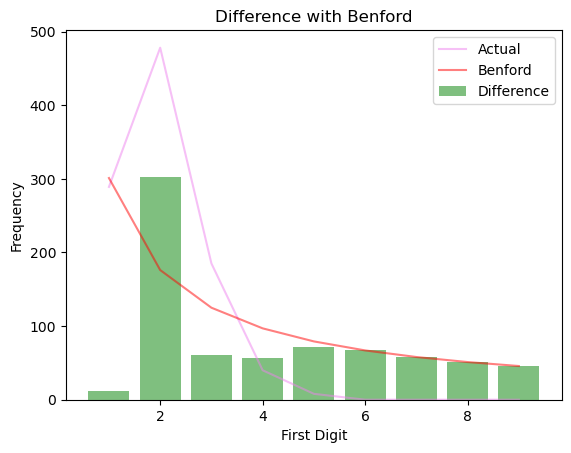

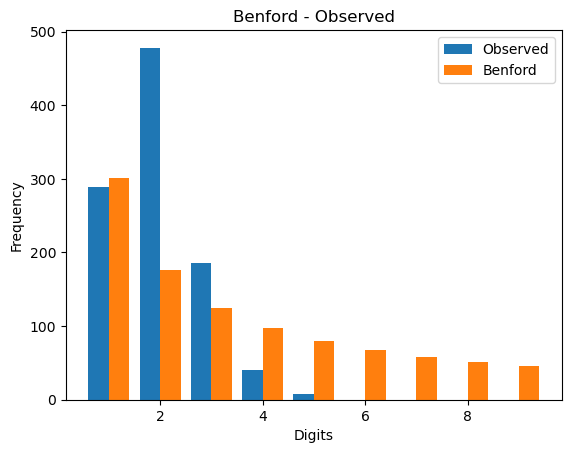

Linearity Check:
Pearson Coefficient: 0.8955551441281107, P-Value: 0.0
R-squared: 0.8020


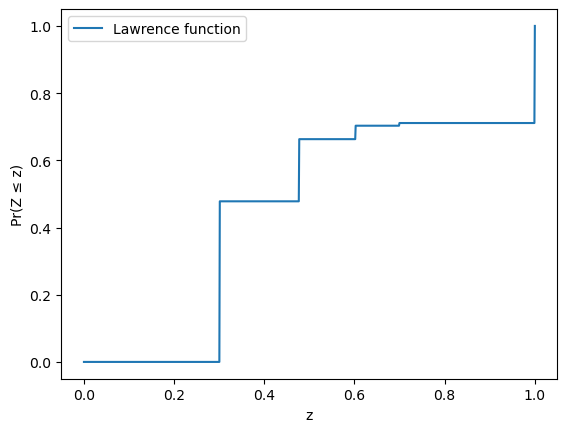

Chi2 Statistic: 1257.1338095509825, Chi2 P-Value: 4.32353977629535e-266
Lawrence Statistics-> c: 1.2571338095509823, m: 0.3010299956639812
MAD Statistic: 0.11067182549009012
MAD result: None
KS Statistic: 0.385 KS P-Value: 1.8608981050282822e-66
Pearson Statistic: -0.07455261808609387 Pearson P-Value: 0.8488243522979625
J-Divergence: nan


/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:148: RuntimeWarning: divide by zero encountered in log2
  first_digits_probes[i] * np.log2(first_digits_probes[i] / benford_probes[i]) +
/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:148: RuntimeWarning: invalid value encountered in scalar multiply
  first_digits_probes[i] * np.log2(first_digits_probes[i] / benford_probes[i]) +
/var/folders/yq/5ch5x8jn4qb69qx20g9_9lqr0000gn/T/ipykernel_16767/1113888228.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  benford_probes[i] * np.log2(benford_probes[i] / first_digits_probes[i])


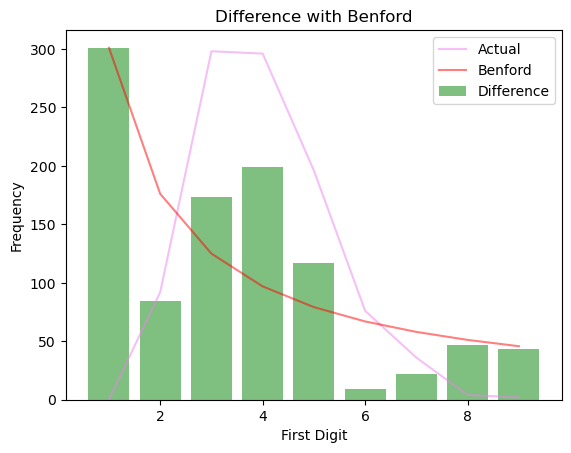

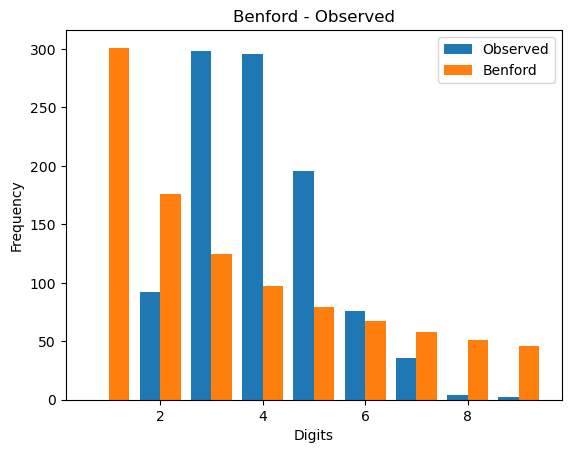

Linearity Check:
Pearson Coefficient: 0.9503148983067307, P-Value: 0.0
R-squared: 0.9031


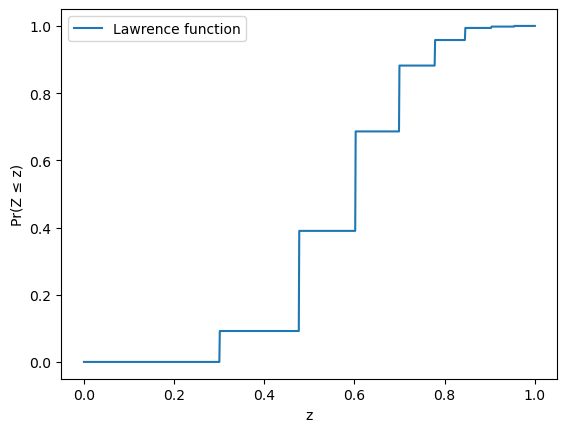

In [24]:
G = nx.watts_strogatz_graph(1000, 3, 0.5)
degrees = [G.degree(n) for n in G.nodes()]
analyzer.set_data(degrees)
analyzer.report()
dist = Distribution(degrees)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


G = nx.watts_strogatz_graph(1000, 5, 0.5)
degrees = [G.degree(n) for n in G.nodes()]
analyzer.set_data(degrees)
analyzer.report()
dist = Distribution(degrees)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()


### - Real Datasets (Golbeck Paper)

In [25]:
twitter = pd.read_csv('twitterAnonymized.tdf', sep='\t')
facebook = pd.read_csv('fbAnonymized.tdf', sep='\t')

In [26]:
twitter.head()

,UserID,Friend_Count,Follower_Count,Status_Count
0,1,138,163,9985
1,2,1,5,14
2,3,39,13,188
3,4,25,59,8
4,5,20,3,1


In [27]:
facebook.head()

,UserID,FriendCount
0,1,753
1,2,540
2,3,258
3,4,247
4,5,279


In [28]:
twitter_friend_counts = twitter['Friend_Count'].to_numpy()
twitter_follower_counts = twitter['Follower_Count'].to_numpy()
facebook_friend_counts = facebook['FriendCount'].to_numpy()

### - Twitter Friend & Follower Count Distribution

Chi2 Statistic: 402.16245171906525, Chi2 P-Value: 6.456421221984231e-82
Lawrence Statistics-> c: 0.005141033054471213, m: 0.025868989328220904
MAD Statistic: 0.007461891693582089
MAD result: None
KS Statistic: 0.03615166312990564 KS P-Value: 7.533272762457886e-45
Pearson Statistic: 0.9989483548709948 Pearson P-Value: 1.2406097117662765e-10
J-Divergence: 0.007442190463958316


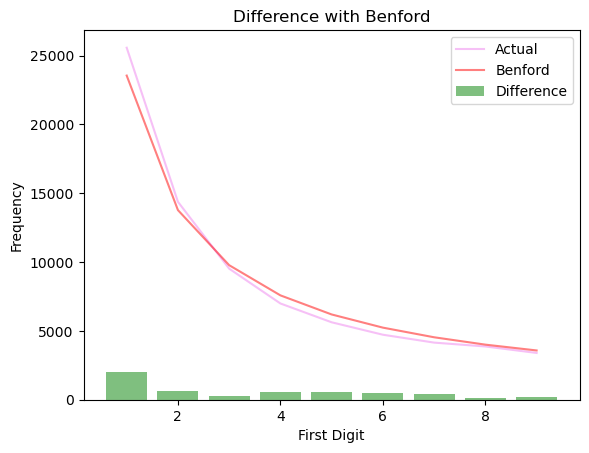

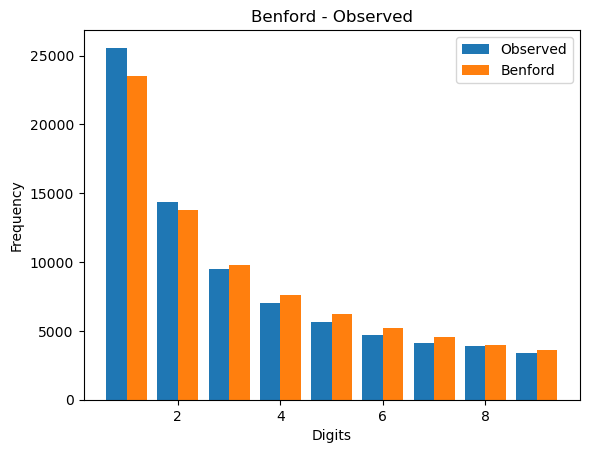

Linearity Check:
Pearson Coefficient: 0.9991204787478218, P-Value: 0.0
R-squared: 0.9982


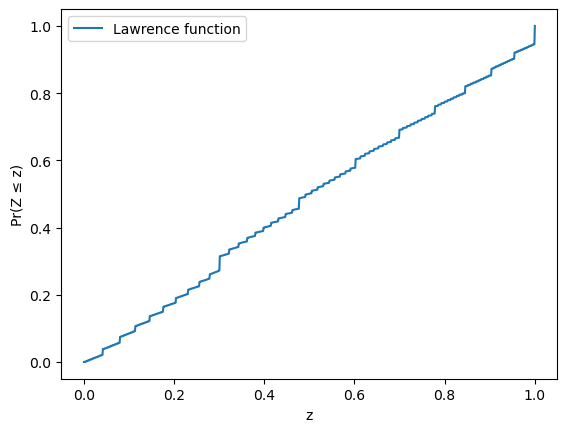

In [29]:
analyzer.set_data(twitter_friend_counts)
analyzer.report()
dist = Distribution(twitter_friend_counts)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

Chi2 Statistic: 843.1221189020985, Chi2 P-Value: 1.0420356352222576e-176
Lawrence Statistics-> c: 0.010778029285686322, m: 0.03499638942537531
MAD Statistic: 0.00996331176726924
MAD result: None
KS Statistic: 0.044281952292076765 KS P-Value: 4.384549490614536e-67
Pearson Statistic: 0.9998278406322575 Pearson P-Value: 2.2040511014031331e-13
J-Divergence: 0.016057130413210816


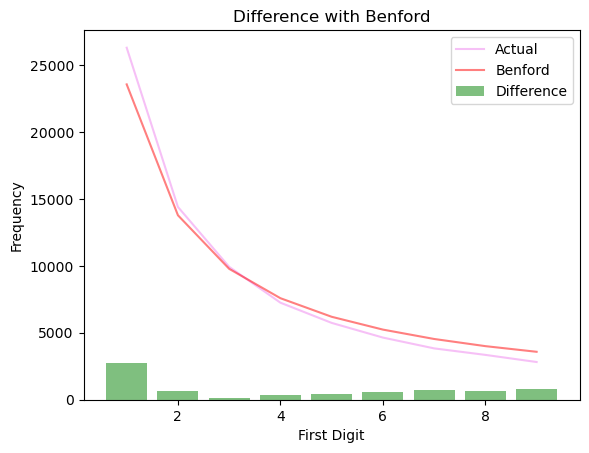

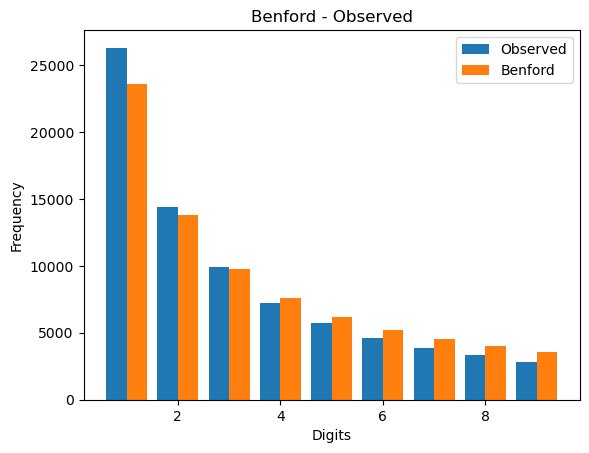

Linearity Check:
Pearson Coefficient: 0.9971332661744825, P-Value: 0.0
R-squared: 0.9943


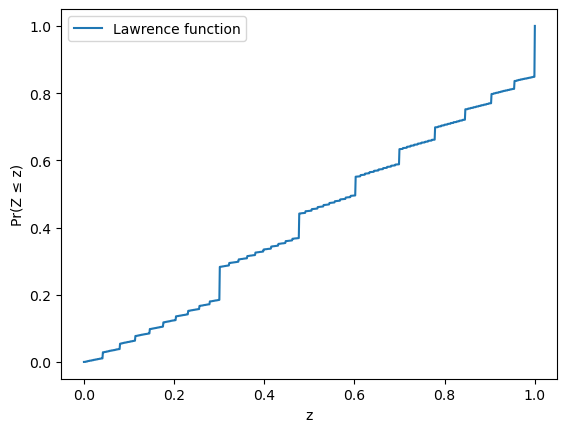

In [30]:
analyzer.set_data(twitter_follower_counts)
analyzer.report()
dist = Distribution(twitter_follower_counts)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()

### - Facebook Friend Count Distribution

Chi2 Statistic: 95.7674727766079, Chi2 P-Value: 3.120698083345892e-17
Lawrence Statistics-> c: 0.005233767230113004, m: 0.022120075382034754
MAD Statistic: 0.007415932295449611
MAD result: None
KS Statistic: 0.030440485298939834 KS P-Value: 8.457867774378572e-08
Pearson Statistic: 0.9995473253215427 Pearson P-Value: 6.495275904432898e-12
J-Divergence: 0.007673948759256512


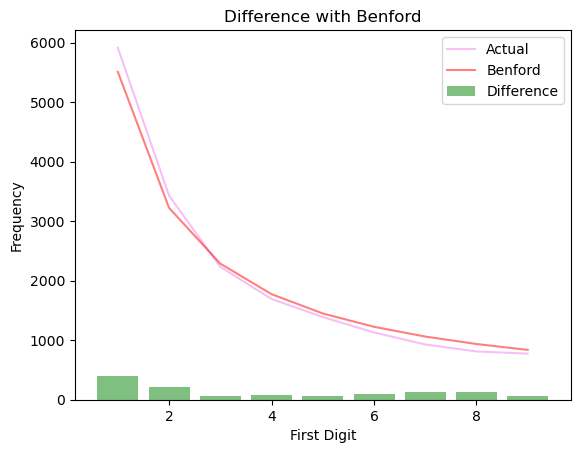

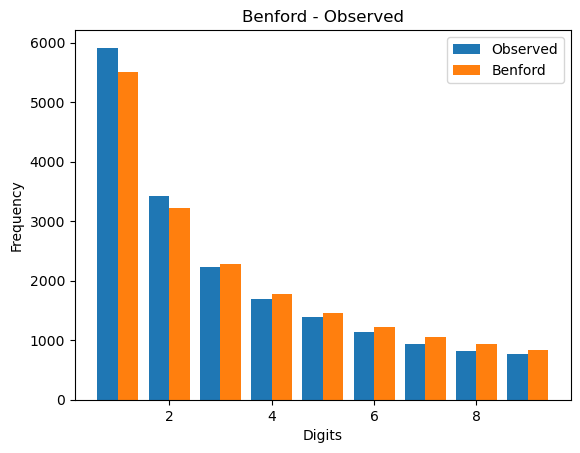

Linearity Check:
Pearson Coefficient: 0.9992571806286129, P-Value: 0.0
R-squared: 0.9985


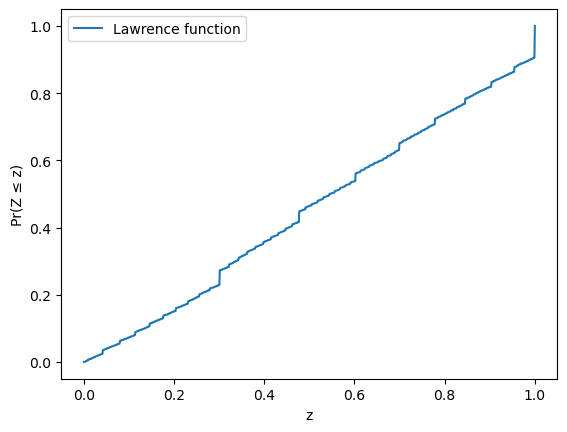

In [31]:
analyzer.set_data(facebook_friend_counts)
analyzer.report()
dist = Distribution(facebook_friend_counts)
lbc = LawrenceBenfordCheck(lambda x: dist.cdf(x), LAWRENCE_DOMAIN)
lbc.compare_cdf_with_benford()